In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from svgpath2mpl import parse_path
import svgpathtools
from svgpathtools import svg2paths, Path
import cairosvg
import matplotlib.image as mpimg
from svgpathtools import svg2paths2
from PIL import Image
import io
import cairosvg
import matplotlib.cm as cm
from datetime import datetime
from scipy.spatial.transform import Rotation as R
from scipy.linalg import cholesky
import math
import quaternion
from scipy.signal import butter, filtfilt, find_peaks
import copy

In [20]:
building = "afeka"
map_heading = 180
scale = 100 / 5
floor_zero = 40
floor_minus_one = 30
routes_filenames = ["_routes.json","_routes_v2.json"]
points_filenames = ["_points.json","_points_2.json"]
building_maps_directory = f"../seeding/{building}/maps"


In [21]:
routes = []
for routes_filename in routes_filenames:
    with open(routes_filename, 'r') as f:
        r = json.load(f)
        routes.extend(r)

In [22]:
versions = []
for points_filename in points_filenames:
    with open(points_filename, 'r') as f:
        version = json.load(f)
        versions.extend(version)

In [23]:
points = []
for version in versions:
    points.extend(version['points'])

In [24]:

def normalize_heading(heading,is_rad=True):
    if is_rad:
        adjusted_heading = (heading - np.radians(map_heading) + 2 * np.pi) % (2 * np.pi)
    else:
        adjusted_heading = (heading - map_heading + 360) % 360

    return adjusted_heading


def normalize_scale(n):
    return  n * scale

def get_floor_by_z(z):
    if z > 40:
        return 0
    else:
        return -1

def get_z_by_floor(floor):
    if floor == 0:
        return floor_zero
    else:
        return floor_minus_one

In [25]:
def get_svg_pathes(directory):
    svg_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".svg"):
            svg_files.append((filename[:-4].replace("_", ""),os.path.join(directory, filename)))
    return svg_files

def read_svg_text(svg_file):
    with open(svg_file, 'r') as f:
        svg_content = f.read()
    return svg_content


def read_svg_content(svg_path):
    paths, attributes = svg2paths(svg_path)
    return paths

def svg_to_mpl(svg_path):
    mpl_paths = []
    for path in svg_path:
        path_str = path.d()
        mpl_path = parse_path(path_str)
        mpl_paths.append(mpl_path)
    return mpl_paths




In [27]:
def radians_to_degrees(radians):
    return radians * (180.0 / math.pi)

def date_string_to_date(date_string):
    dt = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%fZ")
    return dt
    
def ms_to_seconds(ms):
    return ms / 1000

def seconds_to_ms(seconds):
    return seconds * 1000

In [28]:
def euler_to_quaternion(roll, pitch, yaw):
    """
    Convert roll, pitch, yaw to a quaternion.
    Roll, pitch, yaw are in radians.
    """
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)

    qw = cr * cp * cy + sr * sp * sy
    qx = sr * cp * cy - cr * sp * sy
    qy = cr * sp * cy + sr * cp * sy
    qz = cr * cp * sy - sr * sp * cy

    # Normalize quaternion to ensure unit quaternion (norm == 1)
    norm = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
    if norm == 0:
        raise ValueError("Quaternion has zero norm")

    qw /= norm
    qx /= norm
    qy /= norm
    qz /= norm

    return qx, qy, qz, qw


def quaternion_to_euler(qx, qy, qz, qw):
    """
    Convert a quaternion to roll, pitch, yaw.
    Roll, pitch, yaw are returned in radians.
    """
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (qw * qx + qy * qz)
    cosr_cosp = 1 - 2 * (qx * qx + qy * qy)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (qw * qy - qz * qx)
    pitch = np.arcsin(sinp) if np.abs(sinp) <= 1 else np.pi / 2 * np.sign(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (qw * qz + qx * qy)
    cosy_cosp = 1 - 2 * (qy * qy + qz * qz)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw



In [31]:
def get_date_time_diff(dt,dt2):
    delta = dt2 - dt
    delta_in_milliseconds = delta.total_seconds() * 1000
    return delta_in_milliseconds

def get_date_from_iso(date_str):
    dt = datetime.fromisoformat(date_str.replace('Z', '+00:00'))
    return dt

def deep_dict_to_tuple(d):
    """
    Converts a dictionary and its nested dictionaries to a tuple of tuples,
    ensuring deep comparison. Handles nested dictionaries and lists.
    """
    if isinstance(d, dict):
        items = d.items()
        sorted_items = sorted(items)
        return tuple((k, deep_dict_to_tuple(v)) for k, v in sorted_items)
    elif isinstance(d, list):
        return tuple(deep_dict_to_tuple(item) for item in d)
    else:
        return d

def unique_dicts(array_of_dicts):
    """ Returns a list of dictionaries with unique structures from the input array. """
    seen = set()
    unique_dicts = []

    for d in array_of_dicts:
        d_tuple = deep_dict_to_tuple(d)
        if d_tuple not in seen:
            seen.add(d_tuple)
            unique_dicts.append(d)

    return unique_dicts


In [49]:
def display_floor_map(floor,svg_path,points=[],routes=[],floor_only=True):
    offset = np.pi / 2
    arrow_length = 10
    head_width = 5
    head_length = 10
    marker_size = 5
    arrow_z_order = 10
    color_blue = "blue"
    circle_marker = 'o'
    color_red_circle_marker = "r" + circle_marker
    color_blue_circle_marker = "b" + circle_marker

    png_bytes = cairosvg.svg2png(url=svg_path)
    png_image = Image.open(io.BytesIO(png_bytes))
    paths, attributes, svg_attributes = svg2paths2(svg_path)
    width = svg_attributes['width']
    height = svg_attributes['height']
    if "px" in width:
        width = width[:-2]
    if "px" in height:
        height = height[:-2]
    original_width = float(width)
    original_height = float(height)
    dpi = 100
    fig_width = original_width / dpi
    fig_height = original_height / dpi
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    plt.title(f"floor {floor}")
    ax.imshow(png_image)

    for point in points:
        p = point
        x = p['x'] 
        y = p['y']
        if p['floor'] == floor:
            ax.plot(x, y, color_red_circle_marker)  # 'ro' stands for red color and circle marker
            if 'heading' in point:
                yaw = point['heading'] + offset
                dx = np.cos(yaw) * arrow_length  # Adjust the length of the arrow as needed
                dy = np.sin(yaw) * arrow_length  # Adjust the length of the arrow as needed
                ax.arrow(x, y, dx, dy, head_width=head_width, head_length=head_length, fc=color_blue, ec=color_blue,zorder=arrow_z_order)            
        else:
            if not floor_only:
                ax.plot(x,y, color_blue_circle_marker) 

    cmap = cm.get_cmap('tab10', len(routes))
    
    for route_index, route in enumerate(routes):
        points = route['route']
        color = cmap(route_index)
        for i in range(len(points) - 1):
            p1 = points[i]['mapCoordinates']
            p2 = points[i + 1]['mapCoordinates']
            x_coords = [p1['x'], p2['x']]
            y_coords = [p1['y'], p2['y']]
            
            if p1['floor'] == p2['floor'] == floor:
                ax.plot(x_coords, y_coords, marker=circle_marker, markersize=marker_size, color=color, label=f'Route {route_index + 1}')
            elif p1['floor'] == floor or p2['floor'] == floor:
                # Draw edge if one of the nodes is on the current floor
                ax.plot(x_coords, y_coords, 'g-', marker=circle_marker, markersize=marker_size, color=color, label=f'Route {route_index + 1}')
                # Draw points
                if p1['floor'] == floor:
                    ax.plot(p1['x'], p1['y'], circle_marker)
                else:
                    if not floor_only:
                        ax.plot(p1['x'], p1['y'], color_blue_circle_marker)
                    
                if p2['floor'] == floor:
                    ax.plot(p2['x'], p2['y'], circle_marker)
                else:
                    if not floor_only:
                        ax.plot(p2['x'], p2['y'], color_blue_circle_marker)

    ax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right')
    plt.show()



In [50]:
building_floor_maps = get_svg_pathes(building_maps_directory)
building_floor_maps

[('-1', '../seeding/afeka/maps/_-1.svg'),
 ('0', '../seeding/afeka/maps/_0.svg')]

In [51]:
building_floor_maps_data = [{
    "floor":int(s[0]),
    "file_path":s[1],
    "text":read_svg_text(s[1]),
    "paths":read_svg_content(s[1])[0],
    "attributes":read_svg_content(s[1])[1]
} for s in building_floor_maps]
building_floor_maps_data

[{'floor': -1,
  'file_path': '../seeding/afeka/maps/_-1.svg',
  'text': '<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="1326px" height="1207px" style="shape-rendering:geometricPrecision; text-rendering:geometricPrecision; image-rendering:optimizeQuality; fill-rule:evenodd; clip-rule:evenodd" xmlns:xlink="http://www.w3.org/1999/xlink">\n<g><path style="opacity:1" fill="#7f807f" d="M -0.5,-0.5 C 441.5,-0.5 883.5,-0.5 1325.5,-0.5C 1325.5,295.833 1325.5,592.167 1325.5,888.5C 1074.5,888.5 823.5,888.5 572.5,888.5C 572.5,994.5 572.5,1100.5 572.5,1206.5C 381.5,1206.5 190.5,1206.5 -0.5,1206.5C -0.5,804.167 -0.5,401.833 -0.5,-0.5 Z"/></g>\n<g><path style="opacity:1" fill="#fefefe" d="M 2.5,2.5 C 442.5,2.5 882.5,2.5 1322.5,2.5C 1322.5,296.833 1322.5,591.167 1322.5,885.5C 1258.5,885.5 1194.5,885.5 1130.5,885.5C 1130.5,859.167 1130.5,832.833 1130

In [52]:
floor_map = building_floor_maps_data[0]
floor_paths = floor_map['paths']
p = floor_map['file_path']
routes[0]

{'_id': '666b354435d2c5b1c5c9c783',
 'buildingId': 'e384f534f12c984588d8868e',
 'isTest': True,
 'routeName': 'routetest',
 'route': [{'id': 'node_main_front_entrance_path_center',
   'title': 'node_main_front_entrance_path_center',
   'pathType': 'edge_align_intersect',
   'facilityType': 'none',
   'POIId': None,
   'isAvailable': True,
   'availableHeadings': ['down', 'left', 'right'],
   'mapCoordinates': {'x': 624,
    'y': 36,
    'floor': 0,
    'createdAt': '2024-06-13T12:38:07.056Z',
    'updatedAt': '2024-06-13T12:38:07.056Z'},
   'createdAt': '2024-06-13T12:38:07.056Z',
   'updatedAt': '2024-06-13T12:38:07.056Z'},
  {'id': 'node_main_entrance_path_center',
   'title': 'main entrance path center',
   'pathType': 'edge_align_intersect',
   'facilityType': 'none',
   'POIId': None,
   'isAvailable': True,
   'availableHeadings': ['up', 'left', 'right'],
   'mapCoordinates': {'x': 656,
    'y': 36,
    'floor': 0,
    'createdAt': '2024-06-13T12:38:07.056Z',
    'updatedAt': '20

In [53]:
svg_path = building_floor_maps_data[1]['file_path']
png_bytes = cairosvg.svg2png(url=svg_path)
png_image = Image.open(io.BytesIO(png_bytes))
paths, attributes, svg_attributes = svg2paths2(svg_path)
original_width = float(svg_attributes['width'])
original_height = float(svg_attributes['height'])
dpi = 100
fig_width = original_width / dpi
fig_height = original_height / dpi
svg_attributes

{'xmlns': 'http://www.w3.org/2000/svg',
 'version': '1.1',
 'width': '1326',
 'height': '1207'}

/tmp/ipykernel_358054/676264959.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(routes))
/tmp/ipykernel_358054/676264959.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(x_coords, y_coords, 'g-', marker=circle_marker, markersize=marker_size, color=color, label=f'Route {route_index + 1}')


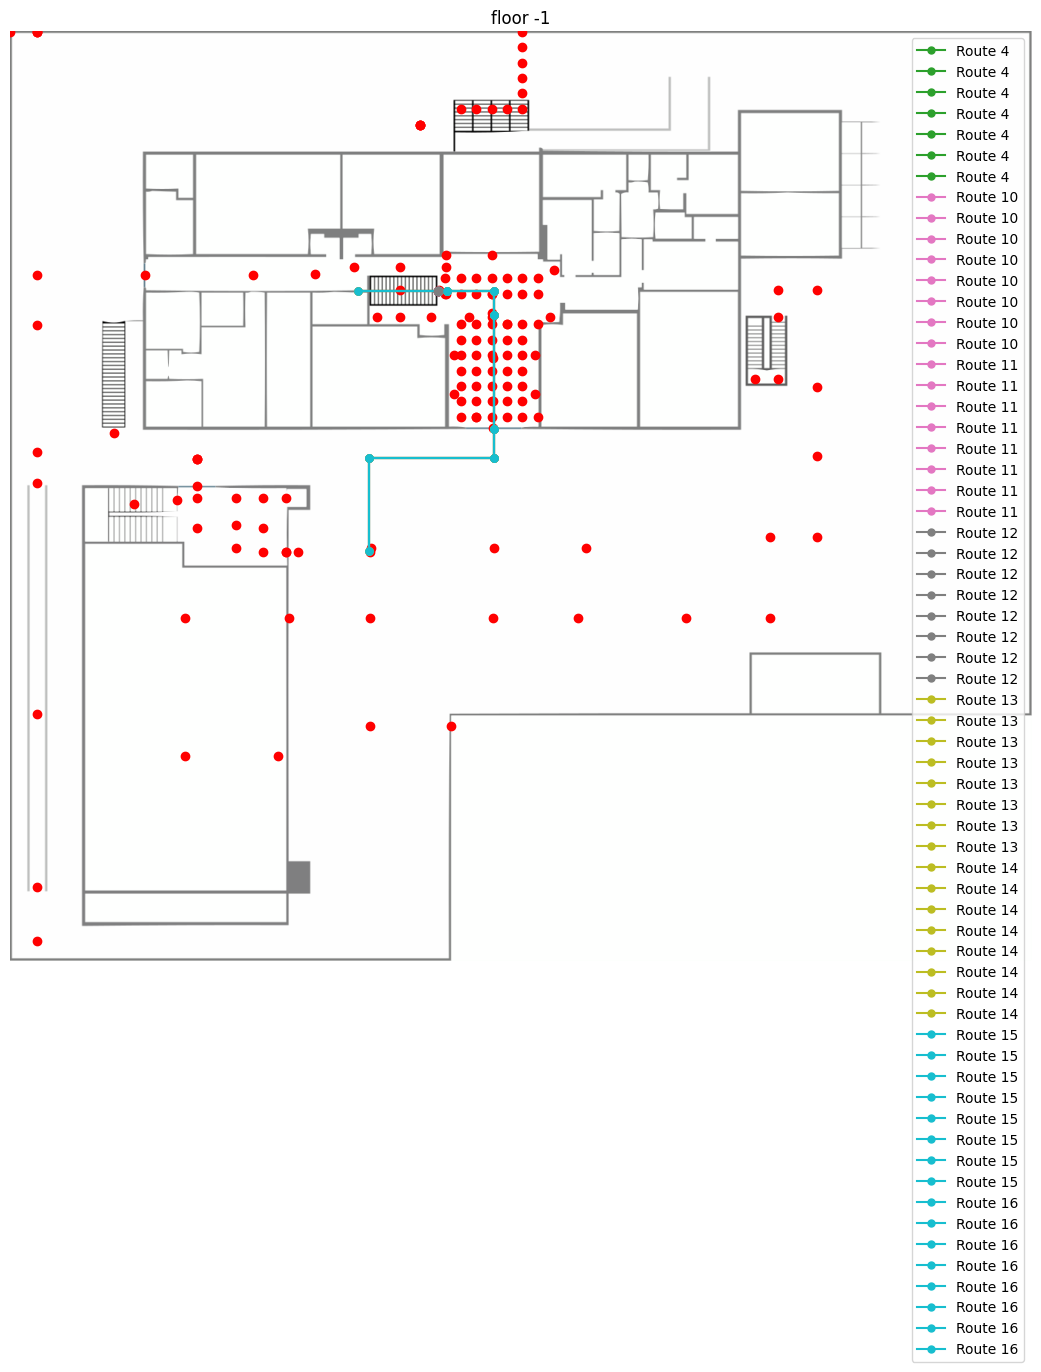

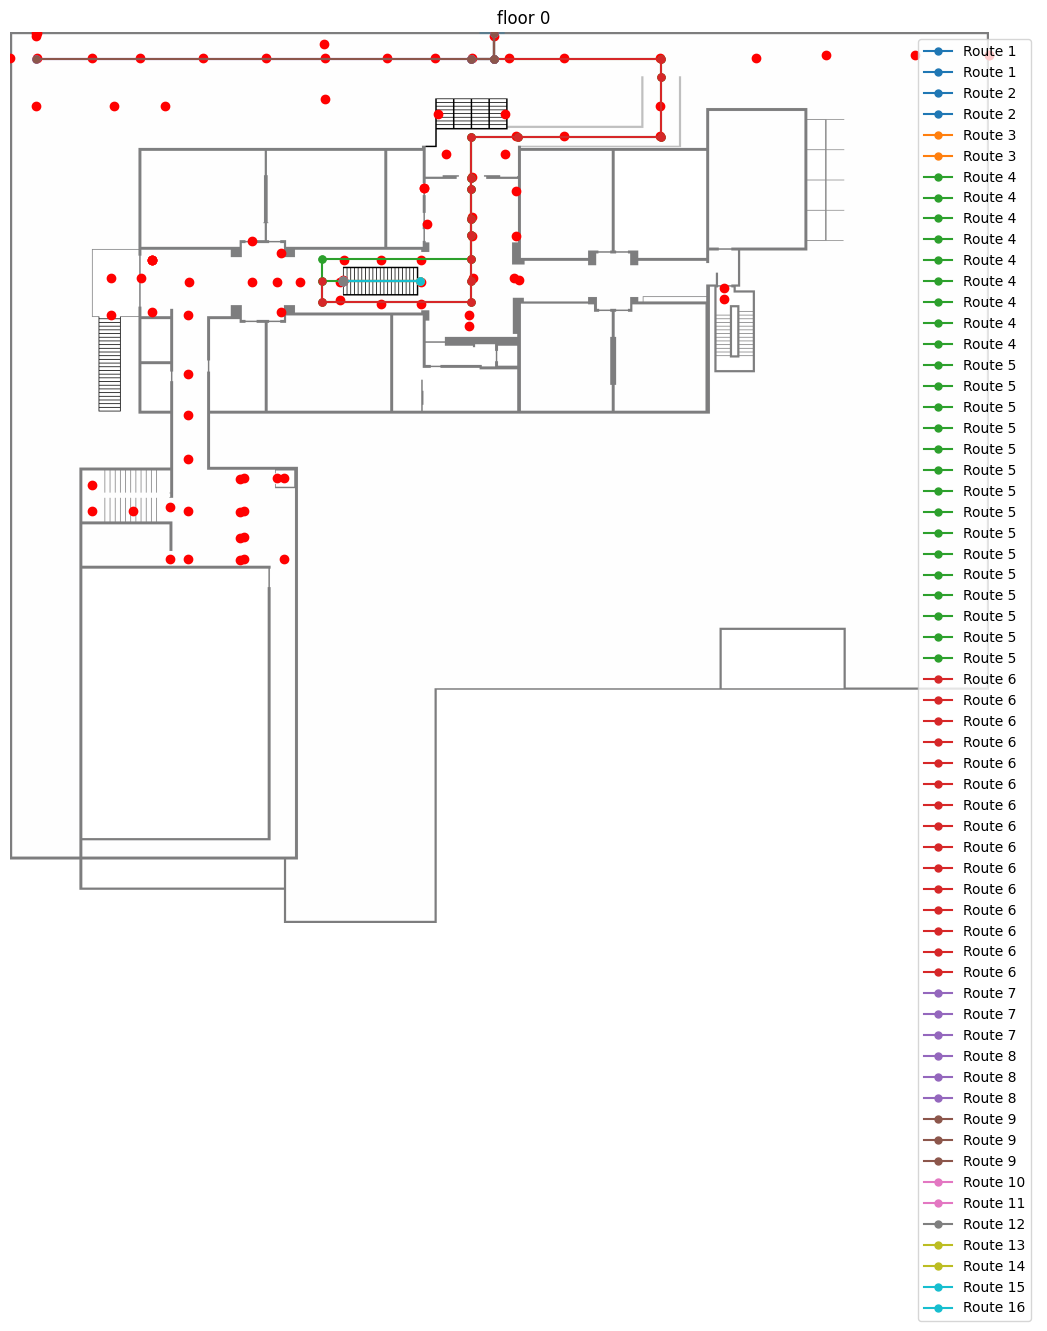

In [54]:
for index,floor_map in enumerate(building_floor_maps_data):
    display_floor_map(floor_map['floor'],floor_map['file_path'],points,routes)

/tmp/ipykernel_358054/676264959.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(routes))


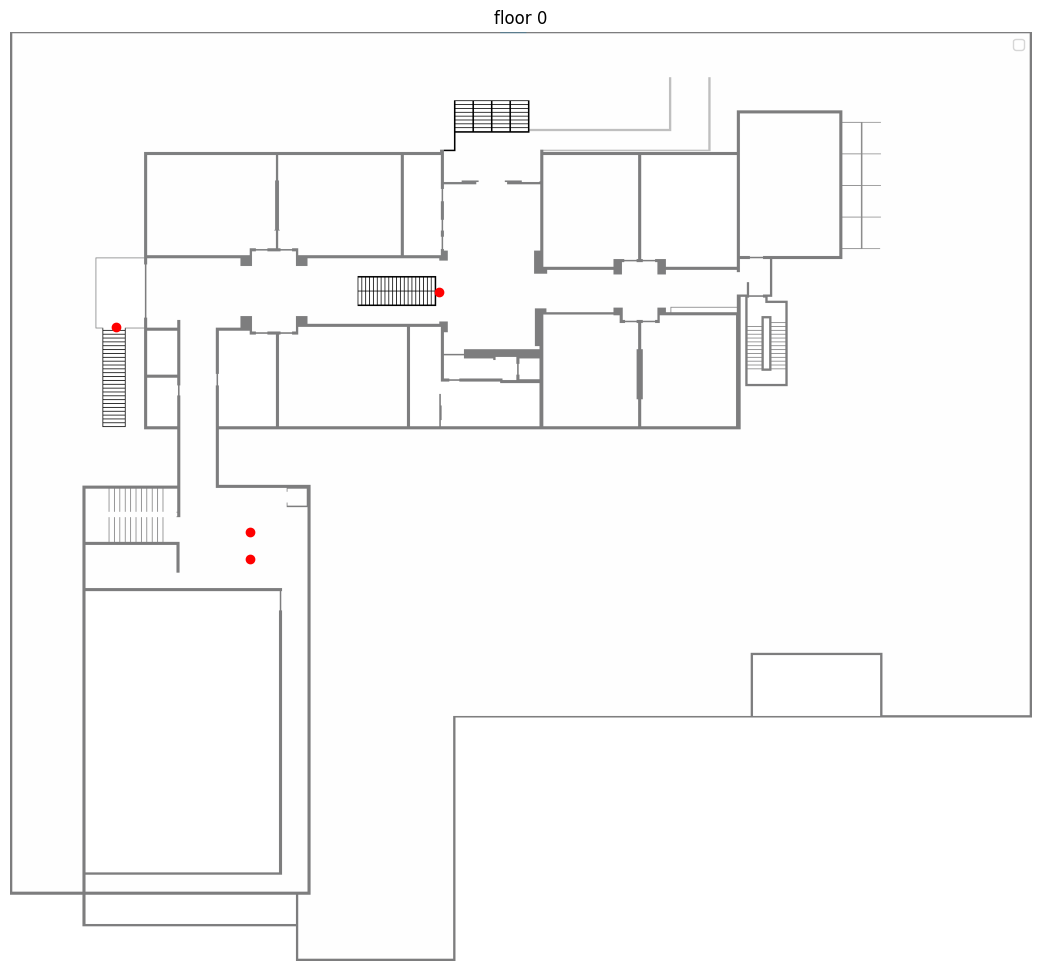

In [55]:
display_floor_map(building_floor_maps_data[1]['floor'],building_floor_maps_data[1]['file_path'],[
    {
        
        "x":557,
        "y":338,
        "floor":0
    },
    {
        "x":137,
        "y":383,
        "floor":0
    },
    {
        "x":311,
        "y":650,
        "floor":0
    },
    {
        "x":311,
        "y":685,
        "floor":0
    },
],[])

/tmp/ipykernel_358054/676264959.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(routes))


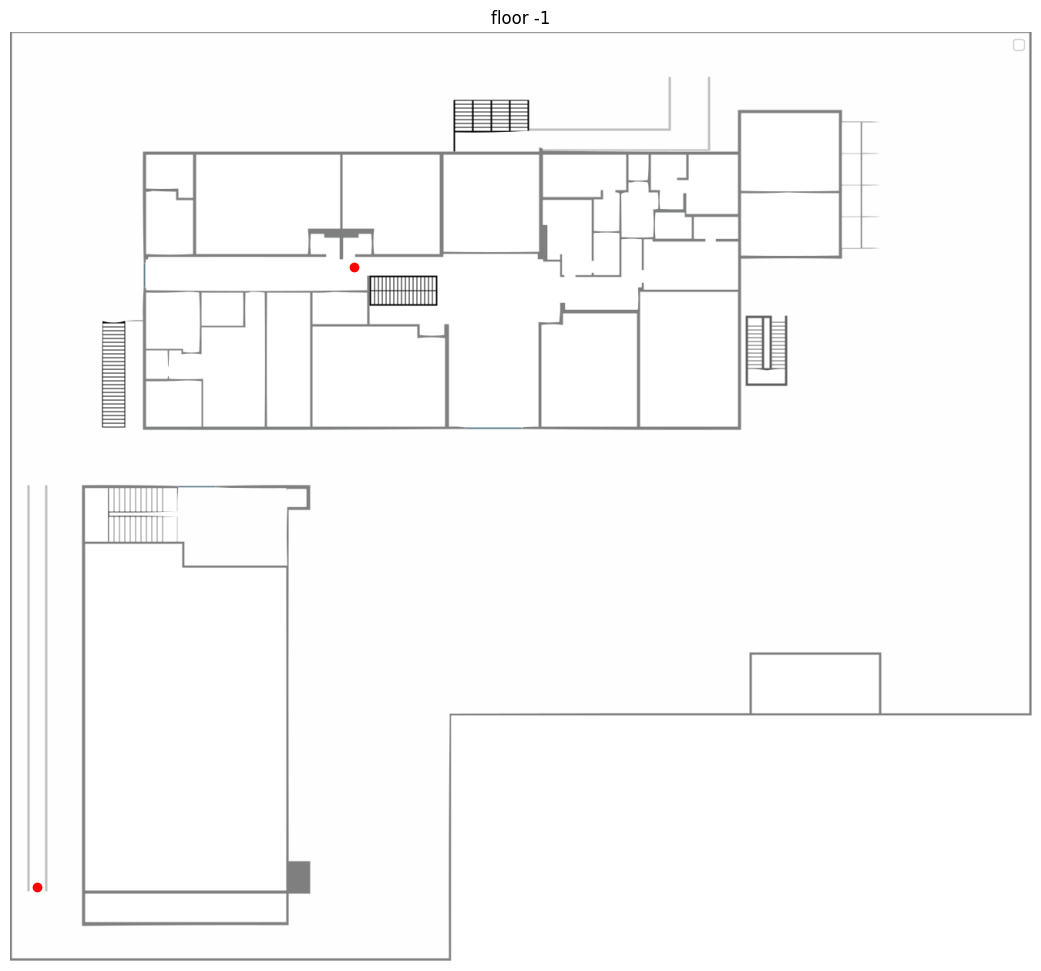

In [56]:
display_floor_map(building_floor_maps_data[0]['floor'],building_floor_maps_data[0]['file_path'],[
    {
        "x":446,
        "y":305,
        "floor":-1
    },
    {
        "x":35,
        "y":1111,
        "floor":-1
    },
    # (1047, 336, -1), (997, 336, -1)
],[])

/tmp/ipykernel_358054/676264959.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(routes))
/tmp/ipykernel_358054/676264959.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(x_coords, y_coords, 'g-', marker=circle_marker, markersize=marker_size, color=color, label=f'Route {route_index + 1}')


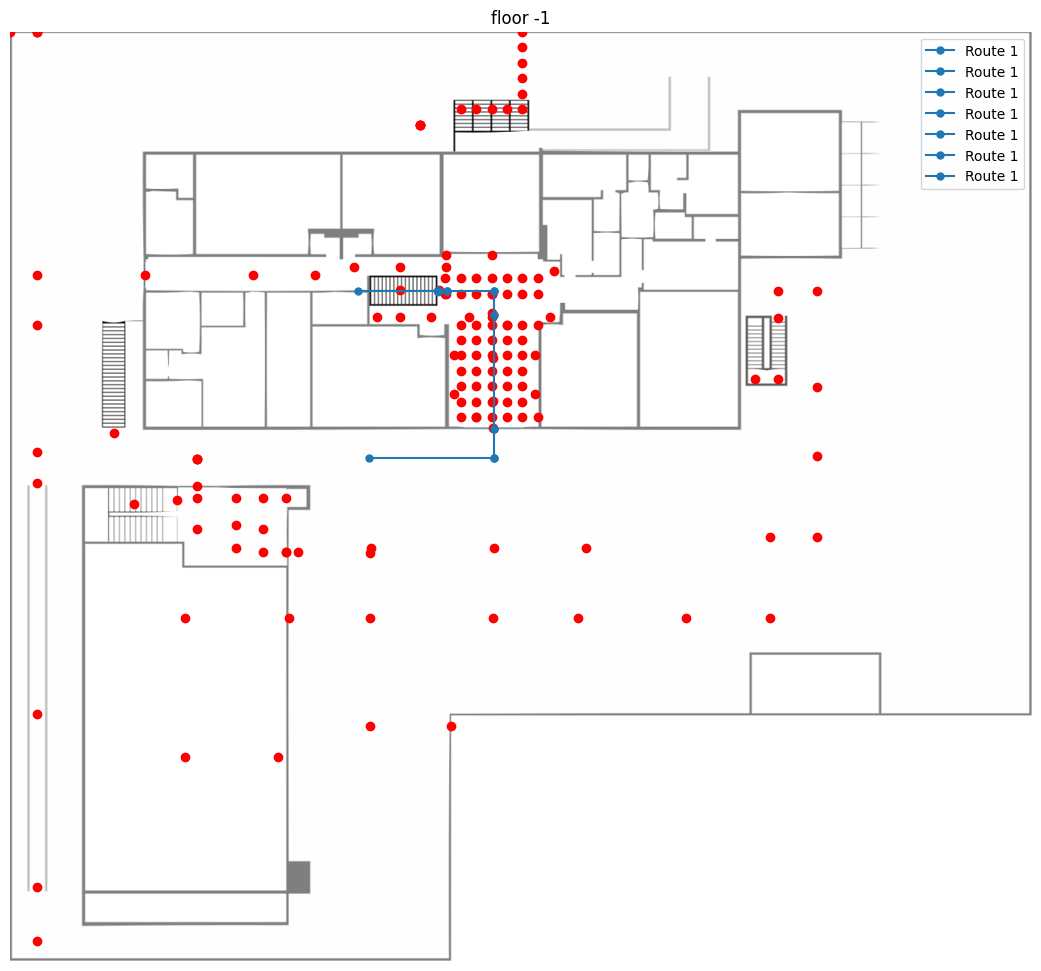

In [57]:
# floor -1
# route 3 - the only route at floor -1
display_floor_map(building_floor_maps_data[0]['floor'],building_floor_maps_data[0]['file_path'],points,[routes[3]])

In [58]:
class KalmanFilter:
    def __init__(self, state_dim, measurement_dim, process_noise ,measurement_noise):
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        self.state = np.zeros(state_dim)
        self.covariance = np.eye(state_dim)
        self.process_noise = process_noise
        self.state_transition = state_transition
        self.measurement_noise = measurement_noise
        self.state_transition = np.eye(state_dim)  
        self.measurement_matrix = np.eye(measurement_dim, state_dim)         

    def predict(self, F, B, u):
        """
        Predict the state and covariance based on the process model.

        Parameters:
        F (np.ndarray): State transition model.
        B (np.ndarray): Control input model.
        u (np.ndarray): Control input.
        """
        self.state = F @ self.state + B @ u
        self.covariance = F @ self.covariance @ F.T + self.process_noise

    def update(self, measurement, H):
        """
        Update the state and covariance based on the measurement.

        Parameters:
        measurement (np.ndarray): The measurement vector.
        H (np.ndarray): Observation model.
        """
        K = self.covariance @ H.T @ np.linalg.inv(H @ self.covariance @ H.T + self.measurement_noise)
        self.state = self.state + K @ (measurement - H @ self.state)
        self.covariance = (np.eye(self.state_dim) - K @ H) @ self.covariance

    def get_state(self):
        """
        Returns the current state estimate.
        """
        return self.state

    def get_covariance(self):
        """
        Returns the current covariance estimate.
        """
        return self.covariance


In [243]:
class ExtendedKalmanFilter(KalmanFilter):
    def predict(self, f, F_jacobian, u):
        """
        Predict the state and covariance for EKF.

        Parameters:
        f (function): Non-linear state transition function.
        F_jacobian (function): Function to compute the Jacobian of f.
        u (np.ndarray): Control input.
        """
        self.state = f(self.state, u)
        F = F_jacobian(self.state, u)
        self.covariance = F @ self.covariance @ F.T + self.process_noise

    def update(self, measurement, h, H_jacobian):
        """
        Update the state and covariance for EKF.

        Parameters:
        measurement (np.ndarray): The measurement vector.
        h (function): Non-linear measurement function.
        H_jacobian (function): Function to compute the Jacobian of h.
        """
        H = H_jacobian(self.state)
        K = self.covariance @ H.T @ np.linalg.inv(H @ self.covariance @ H.T + self.measurement_noise)
        self.state = self.state + K @ (measurement - h(self.state))
        self.covariance = (np.eye(self.state_dim) - K @ H) @ self.covariance


In [244]:
class UnscentedKalmanFilter(KalmanFilter):
    def __init__(self, state_dim, measurement_dim, process_noise, measurement_noise, alpha=1e-3, beta=2, kappa=0):
        super().__init__(state_dim, measurement_dim, process_noise, measurement_noise)
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.lambda_ = alpha**2 * (state_dim + kappa) - state_dim
        self.gamma = np.sqrt(state_dim + self.lambda_)

    def sigma_points(self):
        """
        Generate sigma points and weights.
        """
        sqrt_cov = cholesky(self.covariance)
        points = np.zeros((2 * self.state_dim + 1, self.state_dim))
        points[0] = self.state
        for i in range(self.state_dim):
            points[i + 1] = self.state + self.gamma * sqrt_cov[i]
            points[self.state_dim + i + 1] = self.state - self.gamma * sqrt_cov[i]

        weights_mean = np.full(2 * self.state_dim + 1, 0.5 / (self.state_dim + self.lambda_))
        weights_cov = np.copy(weights_mean)
        weights_mean[0] = self.lambda_ / (self.state_dim + self.lambda_)
        weights_cov[0] = weights_mean[0] + (1 - self.alpha**2 + self.beta)
        
        return points, weights_mean, weights_cov

    def predict(self, f):
        """
        Predict the state and covariance for UKF.

        Parameters:
        f (function): Non-linear state transition function.
        """
        points, weights_mean, weights_cov = self.sigma_points()
        predicted_points = np.array([f(point) for point in points])

        self.state = np.dot(weights_mean, predicted_points)
        self.covariance = self.process_noise
        for i in range(len(predicted_points)):
            diff = predicted_points[i] - self.state
            self.covariance += weights_cov[i] * np.outer(diff, diff)

    def update(self, measurement, h):
        """
        Update the state and covariance for UKF.

        Parameters:
        measurement (np.ndarray): The measurement vector.
        h (function): Non-linear measurement function.
        """
        points, weights_mean, weights_cov = self.sigma_points()
        predicted_points = np.array([h(point) for point in points])

        measurement_prediction = np.dot(weights_mean, predicted_points)
        innovation_covariance = self.measurement_noise
        cross_covariance = np.zeros((self.state_dim, self.measurement_dim))

        for i in range(len(predicted_points)):
            diff_state = points[i] - self.state
            diff_measurement = predicted_points[i] - measurement_prediction
            innovation_covariance += weights_cov[i] * np.outer(diff_measurement, diff_measurement)
            cross_covariance += weights_cov[i] * np.outer(diff_state, diff_measurement)

        K = cross_covariance @ np.linalg.inv(innovation_covariance)
        self.state += K @ (measurement - measurement_prediction)
        self.covariance -= K @ innovation_covariance @ K.T


In [245]:
# # Example usage of Basic Kalman Filter
# kf = KalmanFilter(state_dim=4, measurement_dim=2, process_noise=np.eye(4), measurement_noise=np.eye(2))
# kf.predict(F=np.eye(4), B=np.zeros((4, 1)), u=np.zeros(1))
# kf.update(measurement=np.array([1, 2]), H=np.eye(2, 4))

# # Example usage of Extended Kalman Filter
# ekf = ExtendedKalmanFilter(state_dim=4, measurement_dim=2, process_noise=np.eye(4), measurement_noise=np.eye(2))
# ekf.predict(f=lambda x, u: x, F_jacobian=lambda x, u: np.eye(4), u=np.zeros(1))
# ekf.update(measurement=np.array([1, 2]), h=lambda x: x[:2], H_jacobian=lambda x: np.eye(2, 4))

# # Example usage of Unscented Kalman Filter
# ukf = UnscentedKalmanFilter(state_dim=4, measurement_dim=2, process_noise=np.eye(4), measurement_noise=np.eye(2))
# ukf.predict(f=lambda x: x)
# ukf.update(measurement=np.array([1, 2]), h=lambda x: x[:2])

# REAL 

In [246]:
class StateDefinition:
    POSITION_INDEX = slice(0, 3)  # Slice for x, y, z
    ORIENTATION_INDEX = slice(3, 6)  # Slice for roll, pitch, yaw
    VELOCITY_INDEX = slice(6, 9)  # Slice for vx, vy, vz


In [247]:

class KalmanFilter:
    def __init__(self, state_dim, measurement_dim):
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        self.state = np.zeros(state_dim)  # Initial state
        self.covariance = np.eye(state_dim)  # Initial covariance matrix
        self.process_noise = np.eye(state_dim)  # Process noise matrix
        self.measurement_noise = np.eye(measurement_dim)  # Measurement noise matrix
        self.state_transition = np.eye(state_dim)  # State transition matrix
        self.measurement_matrix = np.eye(measurement_dim, state_dim)  # Measurement matrix

    def predict(self):
        self.state = self.state_transition @ self.state
        self.covariance = self.state_transition @ self.covariance @ self.state_transition.T + self.process_noise

    def update(self, measurement):
        K = self.covariance @ self.measurement_matrix.T @ np.linalg.inv(
            self.measurement_matrix @ self.covariance @ self.measurement_matrix.T + self.measurement_noise)
        self.state = self.state + K @ (measurement - self.measurement_matrix @ self.state)
        self.covariance = (np.eye(self.state_dim) - K @ self.measurement_matrix) @ self.covariance

    def set_state_transition(self, state_transition):
        self.state_transition = state_transition

    def set_process_noise(self, process_noise):
        self.process_noise = process_noise

    def set_measurement_matrix(self, measurement_matrix):
        self.measurement_matrix = measurement_matrix

    def set_measurement_noise(self, measurement_noise):
        self.measurement_noise = measurement_noise

    def get_state(self):
        return self.state

    def get_covariance(self):
        return self.covariance


In [248]:
class PedestrianDeadReckoning:
    def __init__(self, initial_position):
        self.position = np.array(initial_position, dtype=float)  # [x, y, z]

    def update_position(self, step_length, heading, vertical_displacement):
        """
        Update the position based on step length, heading, and vertical displacement.

        Parameters:
        step_length (float): The length of the step taken by the pedestrian.
        heading (float): The heading angle (in radians) relative to a reference direction.
        vertical_displacement (float): The vertical displacement (in meters).
        """
        delta_x = step_length * np.cos(heading)
        delta_y = step_length * np.sin(heading)
        delta_z = vertical_displacement
        self.position += np.array([delta_x, delta_y, delta_z])

    def update_new_position(self,new_position):
        if new_position is not None:
            self.position = new_position

    def get_position(self):
        """
        Returns the current estimated position.
        """
        return self.position


In [249]:
class DeviceQuaternion:
    def __init__(self, initial_quaternion):
        self.quaternion = quaternion.quaternion(*initial_quaternion)

    def update_quaternion(self, new_quaternion):
        """
        Update the device orientation directly with quaternion.

        Parameters:
        new_orientation (list): The new orientation quaternion [w, x, y, z].
        """
        if new_quaternion is not None:
            if isinstance(new_quaternion,quaternion.quaternion):
                self.quaternion = new_quaternion  
            else:
                self.quaternion = quaternion.quaternion(*new_quaternion)

    def get_quaternion(self):
        """
        Returns the current estimated device orientation as quaternion.
        """
        return self.quaternion

    def get_quaternion_as_euler(self):
        """
        Returns the current estimated device orientation as Euler angles.
        """
        return quaternion.as_euler_angles(self.quaternion)


In [250]:
# class PedestrianDeadReckoning:
#     def __init__(self, initial_position, initial_orientation):
#         self.position = np.array(initial_position, dtype=float)  # [x, y, z]
#         self.orientation = quaternion.quaternion(*initial_orientation)  # Quaternion representation of initial orientation

#     def update_position(self, step_length, heading, vertical_displacement):
#         """
#         Update the position based on step length, heading, and vertical displacement.

#         Parameters:
#         step_length (float): The length of the step taken by the pedestrian.
#         heading (float): The heading angle (in radians) relative to a reference direction.
#         vertical_displacement (float): The vertical displacement (in meters).
#         """
#         direction = quaternion.as_rotation_matrix(self.orientation)[:, 0]  # Get the forward direction vector
#         delta_position = step_length * direction
#         delta_position[2] += vertical_displacement
#         self.position += delta_position

#     def get_position(self):
#         """
#         Returns the current estimated position.
#         """
#         return self.position

#     def update_orientation(self, new_orientation):
#         """
#         Update the orientation directly.

#         Parameters:
#         new_orientation (np.ndarray): The new orientation angles [yaw, pitch, roll] in radians.
#         """
#         self.orientation = quaternion.quaternion(*new_orientation)

#     def get_orientation(self):
#         """
#         Returns the current estimated orientation.
#         """
#         return self.orientation

#     def get_euler_angles(self):
#         """
#         Returns the current estimated orientation as euler angles.
#         """        
#         return quaternion.as_euler_angles(self.orientation)

#     def get_state(self):
#         state = []
#         state.extend(self.position)
#         state.extend(self.orientation)
#         return state


In [251]:
class KalmanFilterPDR:
    def __init__(self, initial_position, initial_orientation, state_dim=9, measurement_dim=6):
        self.state_definition = StateDefinition()
        self.kf = KalmanFilter(state_dim, measurement_dim)
        self.pdr = PedestrianDeadReckoning(initial_position, initial_orientation)
        
        # Initialize state: [x, y, z, vx, vy, vz, yaw, pitch, roll]
        initial_state = np.zeros(state_dim)
        self.kf.state = initial_state
        self._set_kf_position(initial_position)
        self._set_kf_orientation(initial_orientation)
        self.kf.measurement_matrix = np.eye(measurement_dim, state_dim)

    def _set_kf_orientation(self, orientation):
        self.kf.state[self.state_definition.ORIENTATION_INDEX] = orientation

    def _set_kf_position(self, position):
        self.kf.state[self.state_definition.POSITION_INDEX] = position

    def _update_kf_state(self,new_state):
        self.kf.state = initial_state

    def predict(self):
        self.kf.predict()

    def update(self, measurement):
        self.kf.update(measurement)

    def update_position(self, step_length, heading, vertical_displacement):
        self.pdr.update_position(step_length, heading, vertical_displacement)
        position = self.pdr.get_position()
        self._set_kf_position(position)

    def update_orientation(self, new_orientation):
        self.pdr.update_orientation(new_orientation)
        orientation = self.pdr.get_orientation()
        self._set_kf_orientation(orientation)

    def get_state(self):
        return self.kf.get_state()

    def get_position(self):
        return self.pdr.get_position()

    def get_orientation(self):
        return self.pdr.get_orientation()



    
# # Example usage
# initial_position = [0, 0, 0]
# initial_orientation = [0, 0, 0]

# kf_pdr = KalmanFilterPDR(initial_position, initial_orientation)

# # Simulated step length, heading, and vertical displacement data (calculated externally)
# step_length = 0.8  # in meters
# heading = np.pi / 4  # 45 degrees in radians
# vertical_displacement = 0.1  # in meters (e.g., going up stairs)

# # Update position and orientation based on external calculations
# kf_pdr.update_position(step_length, heading, vertical_displacement)
# new_orientation = [heading, 0.0, 0.0]  # Assuming only yaw changes for simplicity
# kf_pdr.update_orientation(new_orientation)

# # Perform a prediction and update with some measurement data
# kf_pdr.predict()
# measurement = np.array([kf_pdr.get_position()[0], kf_pdr.get_position()[1], kf_pdr.get_position()[2], 0, 0, 0])
# kf_pdr.update(measurement)

# print("State:", kf_pdr.get_state())
# print("Position:", kf_pdr.get_position())
# print("Orientation:", kf_pdr.get_orientation())


In [252]:

def ekf_update(state, covariance, measurement, measurement_noise, H):
    """
    Perform the update step of the EKF.

    Parameters:
    state: np.ndarray
        The current state vector
    covariance: np.ndarray
        The current covariance matrix
    measurement: np.ndarray
        The measurement vector
    measurement_noise: np.ndarray
        The measurement noise matrix
    H: np.ndarray
        The measurement matrix

    Returns:
    np.ndarray, np.ndarray
        The updated state and covariance
    """
    K = covariance @ H.T @ np.linalg.inv(H @ covariance @ H.T + measurement_noise)
    state = state + K @ (measurement - H @ state)
    covariance = (np.eye(len(state)) - K @ H) @ covariance
    return state, covariance


In [253]:
# test_route = routes[3]
# test_route_points = [r['mapCoordinates'] for r in test_route['route']]
# test_route_data = test_route['data']['alldata']
# test_route_checkpoints = test_route['checkpoints'] 
# start_location = test_route_points[0]
# start_location

# processed_route = {
#     "route": transform(test_route['route'])
# }

# for i in range(len(test_route_points) - 1):
#     prev = test_route_points[i]
#     current = test_route_points[i + 1]



# # 1 pixel = 0.05 meters
# display_floor_map(building_floor_maps_data[0]['floor'],building_floor_maps_data[0]['file_path'],[
#     {
#         "x":575,
#         "y":100,
#         "floor":-1
#     },
#         {
#         "x":575 + 100,
#         "y":100,
#         "floor":-1
#     }
# ],[routes[3], processed_route])

In [254]:

# def get_route_data(index):
#     route_data = routes[index]
    
#     route_points = [{
#         'x':r['mapCoordinates']['x'], 
#         'y':r['mapCoordinates']['y'], 
#         'floor': r['mapCoordinates']['floor']
#         } for r in test_route['route']]
#     route_data = test_route['data']['alldata']
#     # for i in range(len(routes_data) - 1):
#     #     print(list(route_data[0].keys()))
#     # print(route_data[0]['gyroscope']['timestamp'])
#     # print(get_date_time_diff(get_date_from_iso(route_data[1]['gyroscope']['timestamp']),get_date_from_iso(route_data[2]['gyroscope']['timestamp'])))

#     data = [d for d in route_data]
#     checkpoints = [{
#         'index':c['index'],
#         'x':c['point']['mapCoordinates']['x'],
#         'y':c['point']['mapCoordinates']['y'],
#         'floor':c['point']['mapCoordinates']['floor'],
#         'time':c['time'],
#         'availableHeadings':c['point']['availableHeadings']
#     } for c in test_route['checkpoints']]
#     return (route_points,checkpoints,data)

# # route_points,route_checkpoints,route_data = get_route_data(3)
# # len(route_data)



In [255]:
def get_route_data(index):
    route = routes[index]
    
    route_points = [{
        'x':r['mapCoordinates']['x'], 
        'y':r['mapCoordinates']['y'], 
        'floor': r['mapCoordinates']['floor']
        } for r in route['route']]
        
    route_data = route['data']['alldata']
    # print(route_data[0]['gyroscope']['timestamp'])
    # print(get_date_time_diff(get_date_from_iso(route_data[1]['gyroscope']['timestamp']),get_date_from_iso(route_data[2]['gyroscope']['timestamp'])))

    data = [d for d in route_data]
    checkpoints = [{
        'index':c['index'],
        'x':c['point']['mapCoordinates']['x'],
        'y':c['point']['mapCoordinates']['y'],
        'floor':c['point']['mapCoordinates']['floor'],
        'time':c['time'],
        'availableHeadings':c['point']['availableHeadings']
    } for c in route['checkpoints']]
    return (route_points,checkpoints,data)

In [256]:



# def user_states_to_route(user_states):
#     route = {
#         "route":[{
#             "mapCoordinates":{
#                 "x":u['position']['x'],
#                 "y":u['position']['y'],
#                 "floor":get_floor_by_z(u['position']['z'])
#             }
#         } for u in user_states]
#     }
#     return route
    
# def user_states_to_points(user_states):
#     points = [
#         {
#             "x":u['position']['x'],
#             "y":u['position']['y'],
#             "floor":-1
#         } for u in user_states
#     ]
#     return points
    
# def user_state_to_state(user_state:dict):
#     o = user_state['orientation']
#     q = euler_to_quaternion(o['roll'],o['pitch'],o['yaw'])
#     position = user_state['position']
#     velocity = user_state['velocity']
#     angular_velocity = user_state['angular_velocity']
#     errors = user_state['errors']
#     state = []
#     state.extend([position['x'],position['y'],position['z']])
#     state.extend([velocity['vx'],velocity['vy'],velocity['vz']])
#     state.extend([angular_velocity['gx'],angular_velocity['gy'],angular_velocity['gz']])
#     state.extend(q)
#     state.extend([errors['accelerometer_error'],errors['magnetometer_error'],errors['gyroscope_error']])
#     return state

# def state_to_user_state(state):
#     euler = quaternion_to_euler(state[9],state[10],state[11],state[12])
#     user_state = {
#         'position':{
#             'x':state[0],
#             'y':state[1],
#             'z':state[2],
#         },
#         'velocity':{
#             'vx':state[3],
#             'vy':state[4],
#             'vz':state[5],
#         },
#         'angular_velocity':{
#             'gx':state[6],
#             'gy':state[7],
#             'gz':state[8],
#         },
#         'orientation':{
#             'roll':euler[0],
#             'pitch':euler[1],
#             'yaw':euler[2]
#         },
#         'errors':{
#             'accelerometer_error':state[13],
#             'magnetometer_error':state[14],
#             'gyroscope_error':state[15],
#         }
#     }
#     return user_state


# def get_route_start_location(route_index):
#     route_points,route_checkpoints,route_data = get_route_data(route_index)
#     p = route_points[0]
#     c = route_checkpoints[0]
#     d = route_data[0]
#     v = d['rotationVector']['data']['data']
#     g = d['gyroscope']['data']['data']
#     a = d['accelerometer']['data']
#     va = a[len(a) - 1]['data']
    
#     user_state = {
#         'orientation':{
#             'roll':0,
#             'pitch':0,
#             'yaw':0
#         },
#         'position':{
#             'x':p['x'],
#             'y':p['y'],
#             'z':get_z_by_floor(p['floor']),
#         },
#         'velocity':{
#             'vx':va['x'],
#             'vy':va['y'],
#             'vz':va['z'],
#         },
#         'angular_velocity':{
#             'gx':g['x'],
#             'gy':g['y'],
#             'gz':g['z'],
#         },
#         # 'quaternion':{
#         #     'qz': v['qz'],
#         #     'qy': v['qy'],
#         #     'qx': v['qx'],
#         #     'qw': v['qw'],
#         # },
#         'errors':{
#             'accelerometer_error':0,
#             'magnetometer_error':0,
#             'gyroscope_error':0,
#         }
#     }
#     return user_state

# get_route_start_location(3)



In [257]:
def update_position_with_pdr(state, step_length, heading_change, dt, scale, offset):
    """
    Update the position in the state vector using Pedestrian Dead Reckoning (PDR).

    Parameters:
    state: np.ndarray
        The current state vector [x, y, z, vx, vy, vz, qx, qy, qz, qw, wx, wy, wz, err_gy, err_acc, err_mag]
    step_length: float
        The length of each step
    heading_change: np.ndarray
        The change in heading direction [delta_heading_x, delta_heading_y, delta_heading_z]
    dt: float
        The time step
    scale: float
        The scaling factor for converting pixels to meters
    offset: float
        The offset in degrees to be applied to the heading direction

    Returns:
    np.ndarray
        The updated state vector
    """
    
    # Extract state variables
    position = state[0:3]
    orientation = state[6:10]

    # Convert quaternion to rotation matrix
    r = R.from_quat(orientation)
    rotation_matrix = r.as_matrix()

    # Apply the offset to the heading direction
    offset_rad = np.radians(offset)
    offset_rotation = R.from_euler('z', offset_rad).as_matrix()
    heading_change = offset_rotation @ heading_change

    # Calculate heading direction
    heading = rotation_matrix @ heading_change

    # Update position using PDR, converting step length to appropriate scale
    # position += heading * step_length * dt

    # Update the state vector
    state[0:3] = position

    return state


In [258]:
# def update_position(state, dt):
#     """
#     Update the position in the state vector.

#     Parameters:
#     state: np.ndarray
#         The current state vector [x, y, z, vx, vy, vz, qx, qy, qz, qw, wx, wy, wz, err_gy, err_acc, err_mag]
#     dt: float
#         The time step

#     Returns:
#     np.ndarray
#         The updated state vector
#     """
#     # Extract state variables
#     position = state[0:3]
#     velocity = state[3:6]
#     accel = state[13:16]

#     # Update position using velocity and acceleration
#     position += velocity * dt + 0.5 * accel * dt**2

#     # Update the state vector
#     state[0:3] = position

#     return state


# # def ekf_predict(state, covariance, process_noise, dt, accel, gyro):
# #     st = state_to_user_state(state)
    
# #     # Update position and velocity
# #     state[0:3] += state[3:6] * dt + 0.5 * accel * dt**2
# #     state[3:6] += accel * dt

# #     # Update orientation
# #     omega = gyro * dt
# #     r = R.from_quat(state[6:10])
# #     r = r * R.from_rotvec(omega)
# #     state[6:10] = r.as_quat()

# #     # State transition matrix
# #     F = np.eye(10)
# #     F[0:3, 3:6] = np.eye(3) * dt

# #     covariance = F @ covariance @ F.T + process_noise
# #     return state, covariance

# def ekf_predict(state, covariance, process_noise, dt, accel, gyro):
#     """
#     Perform the prediction step of the EKF.

#     Parameters:
#     state: np.ndarray
#         The current state vector [x, y, z, vx, vy, vz, qx, qy, qz, qw, wx, wy, wz, err_gy, err_acc, err_mag]
#     covariance: np.ndarray
#         The current covariance matrix
#     process_noise: np.ndarray
#         The process noise matrix
#     dt: float
#         The time step
#     accel: np.ndarray
#         The acceleration vector [ax, ay, az]
#     gyro: np.ndarray
#         The gyroscope vector [gx, gy, gz]

#     Returns:
#     np.ndarray, np.ndarray
#         The predicted state and covariance
#     """
#     # Extract state variables
#     velocity = state[3:6]
#     orientation = state[6:10]
#     angular_velocity = state[10:13]

#     # Convert quaternion to rotation matrix
#     r = R.from_quat(orientation)
#     rotation_matrix = r.as_matrix()

#     # Update velocity using acceleration (account for orientation)
#     accel_world = rotation_matrix @ accel
#     velocity += accel_world * dt

#     # Update orientation using gyroscope angular velocity
#     omega = angular_velocity * dt
#     r = r * R.from_rotvec(omega)
#     orientation = r.as_quat()

#     # Update angular velocity using gyroscope
#     angular_velocity += gyro * dt

#     # Update the state vector
#     state[3:6] = velocity
#     state[6:10] = orientation
#     state[10:13] = angular_velocity

#     # State transition matrix (F) for 16-state system
#     F = np.eye(16)
#     F[3:6, 3:6] = np.eye(3)  # Velocity updates

#     covariance = F @ covariance @ F.T + process_noise
#     return state, covariance


# # def ekf_update(state, covariance, measurement, measurement_noise, H):
# #     K = covariance @ H.T @ np.linalg.inv(H @ covariance @ H.T + measurement_noise)
# #     state = state + K @ (measurement - H @ state)
# #     covariance = (np.eye(len(state)) - K @ H) @ covariance
# #     return state, covariance


In [294]:
class Route:
    def __init__(self,route_index,floor_index):
        self.route_index = route_index
        self.route = routes[route_index]
        route_points,route_checkpoints,route_data = get_route_data(route_index)
        self.route_points = route_points
        self.route_checkpoints = route_checkpoints
        self.route_data = route_data
        self.floor_index = floor_index
        
    def get_route(self):
        return self.route

    @staticmethod
    def get_accel_data(data_t): # since i save the last 5 values , for step detection , but for now we can just try without
        if "accelerometer" in data_t:
            accelerometer_data = data_t['accelerometer']['data'] 
            num_values = len(accelerometer_data)
            last_accelerometer_data = accelerometer_data[num_values - 1]['data']
            z_accel = np.array([last_accelerometer_data['x'] , last_accelerometer_data['y'], last_accelerometer_data['z'] ])
            return z_accel

    @staticmethod
    def get_accel_buffer(data_t):
        if "accelerometer" in data_t:
            accelerometer_data = data_t['accelerometer']['data'] 
            buffer = []
            for a in accelerometer_data:
                accel = a['data']
                z_accel = np.array([accel['x'] , accel['y'], accel['z']])
                buffer.append(z_accel)
            return buffer

    @staticmethod
    def get_gyro_data(data_t):
        if "gyroscope" in data_t:
            gyroscope_data = data_t['gyroscope']['data']['data']
            z_gyro = np.array([gyroscope_data['x'], gyroscope_data['y'], gyroscope_data['z']])
            return z_gyro

    @staticmethod
    def get_mag_data(data_t):
        if "magnetometer" in data_t:
            magnetometer_data = data_t['magnetometer']['data']['data']
            z_mag = np.array([magnetometer_data['x'], magnetometer_data['y'], magnetometer_data['z']])
            return z_mag

    @staticmethod
    def get_rotation_vector_data(data_t):
        if "rotationVector" in data_t:
            rotation_vector_data = data_t['rotationVector']['data']['data']
            z_rotation = np.array([rotation_vector_data['roll'], rotation_vector_data['pitch'], rotation_vector_data['yaw']])
            return z_rotation            

    @staticmethod
    def get_full_rotation_vector_data(data_t):
        if "rotationVector" in data_t:
            rotation_vector_data = data_t['rotationVector']['data']['data']
            estimatedHeadingAccuracy = rotation_vector_data["estimatedHeadingAccuracy"]
            orientation = np.array([
                rotation_vector_data['roll'], 
                rotation_vector_data['pitch'], 
                rotation_vector_data['yaw']
            ])
            vector = np.array([
                rotation_vector_data['x*sin(θ/2)'], 
                rotation_vector_data['y*sin(θ/2)'], 
                rotation_vector_data['z*sin(θ/2)'],
                rotation_vector_data['cos(θ/2)'],
            ])
            quaternion = np.array([
                rotation_vector_data['qx'], 
                rotation_vector_data['qy'], 
                rotation_vector_data['qz'],
                rotation_vector_data['qw'],
            ])

            return estimatedHeadingAccuracy,vector,quaternion,orientation
        
    @staticmethod
    def get_linear_accel_data(data_t):
        if "linear" in data_t:
            linear_data = data_t['linear']['data']['data']
            z_linear = np.array([linear_data['x'], linear_data['y'], linear_data['z']])
            return z_linear                       

    @staticmethod
    def get_gravity_data(data_t):
        if "gravity" in data_t:
            gravity_data = data_t['gravity']['data']['data']
            z_grav = np.array([gravity_data['x'], gravity_data['y'], gravity_data['z']])
            return z_grav                       

    @staticmethod
    def get_gps_data(data_t):
        if "gpsData" in data_t:
            pass

    @staticmethod
    def get_timestamp(data_t):
        timestamps = set()
        for key, value in data_t.items():
            timestamp = value['timestamp']
            dt = date_string_to_date(timestamp)
            timestamp = dt.timestamp()
            timestamps.add(timestamp)
        main_timestamp = min(timestamps)
        return main_timestamp


    def checkpoints(self):
        return self.route_checkpoints


In [299]:
class UserRoute:
    def __init__(self,route_index,floor_index,initial_index=0):
        self.state_definition = StateDefinition()
        self.route = Route(route_index,floor_index)
        initial_position,initial_quaternion,initial_timestamp = self.get_initial_location(initial_index)
        self.initial_position = initial_position
        self.initial_quaternion = initial_quaternion
        self.initial_timestamp = initial_timestamp
        self.user_states = []
        self.INS = InterialNavigationSystem(initial_position,initial_quaternion,initial_timestamp)
        self.accel_data = {'x': [], 'y': [], 'z': []}
        self.gyro_data = {'x': [], 'y': [], 'z': []}
        self.mag_data = {'x': [], 'y': [], 'z': []}


    def get_initial_location(self,initial_index):
        p = self.route.route_points[initial_index]
        c = self.route.route_checkpoints[initial_index]
        d = self.route.route_data[initial_index]
        initial_position = [p['x'],p['y'],get_z_by_floor(p['floor'])]
        initial_orientation_data = self.route.get_full_rotation_vector_data(d)
        estimatedHeadingAccuracy,vector,initial_quaternion,orientation = initial_orientation_data
        initial_timestamp = self.route.get_timestamp(d)
        return initial_position,initial_quaternion,initial_timestamp

    def calculate(self,func,start_at=None,break_at=None,every_x=None,specifics=[]):
        self.user_states = [self.initial_position]
        self.accel_data = {'x': [], 'y': [], 'z': []}
        self.gyro_data = {'x': [], 'y': [], 'z': []}
        self.mag_data = {'x': [], 'y': [], 'z': []}        
        i = 0
        for data_t in self.route.route_data:
            if start_at and i < start_at:
                i += 1
                continue

            timestamp = Route.get_timestamp(data_t)    
            accel = Route.get_accel_data(data_t)
            gyro = Route.get_gyro_data(data_t) 
            mag = Route.get_mag_data(data_t)
            # Collect sensor data
            self.accel_data['x'].append(accel[0])
            self.accel_data['y'].append(accel[1])
            self.accel_data['z'].append(accel[2])

            self.gyro_data['x'].append(gyro[0])
            self.gyro_data['y'].append(gyro[1])
            self.gyro_data['z'].append(gyro[2])

            self.mag_data['x'].append(mag[0])
            self.mag_data['y'].append(mag[1])
            self.mag_data['z'].append(mag[2])
            
            user_state = self.INS.calculate_new_user_position(data_t)
            if (every_x and i % every_x == 0) or i in specifics:
                func(user_state)
            self.user_states.append(user_state)
            if break_at and i == break_at:
                break     
            i += 1
    

    def _get_position_from_user_state(self, user_state):
        return user_state[self.state_definition.POSITION_INDEX]

    def _get_orientation_from_user_state(self,user_state):
        return user_state[self.state_definition.ORIENTATION_INDEX]


    def get_user_route(self):        
        route = []
        for user_state in self.user_states:

            position = self._get_position_from_user_state(user_state)
            orientation = self._get_orientation_from_user_state(user_state)

            route_checkpoint = {
                "mapCoordinates":{
                    "x":position[0],
                    "y":position[1],
                    "floor":get_floor_by_z(position[2]),
                    "heading":orientation[2]
                }
            }            
            route.append(route_checkpoint)

        user_route = {
            "route":route
        }
        return user_route

    
    def get_user_route_points(self,skips_specifics=[],headings_specifics=[],every_x=None):
        points = []
        i = 0
        for index,user_state in enumerate(self.user_states):
            if i in skips_specifics:
                i += 1    
                continue

            position = self._get_position_from_user_state(user_state)
            orientation = self._get_orientation_from_user_state(user_state)
            
            point = {
                "x":position[0],
                "y":position[1],
                "floor":-1,
            }
            if i in headings_specifics or (every_x and i % every_x == 0):
                point['heading'] = normalize_heading(orientation[2])
            points.append(point)

            i += 1
        return points


    def display_route(self,route_start_index=None,route_end_index=None,skips_specifics=[],headings_specifics=[],every_x=None):
        display_points = self.get_user_route_points(skips_specifics,headings_specifics,every_x)
        index = self.route.floor_index
        route = self.route.get_route()['route'].copy()
        
        if route_start_index and route_end_index is None:
            route = route['route'][route_start_index:]

        if route_end_index and route_start_index is None:
            route = route['route'][0:route_end_index]
        
        if route_end_index is not None and route_start_index is not None:
            route = route[route_start_index:route_end_index]

        target_route = {
            "route":route
        }

        display_floor_map(
            building_floor_maps_data[index]['floor'],
            building_floor_maps_data[index]['file_path'],
            display_points,
            [target_route],
            False
        )

    def get_checkpoints(self):
        return self.route.checkpoints()

    def points_until_checkpoint(self,checkpoint_index):
        if checkpoint_index == 0:
            return None
        checkpoints = self.route.checkpoints()
        checkpoint = checkpoints[checkpoint_index]
        checkpoint_time = checkpoint['time']
        checkpoint_timestamp = date_string_to_date(checkpoint_time).timestamp()

        prev_checkpoint_index = checkpoint_index - 1        
        prev_checkpoint = checkpoints[prev_checkpoint_index]
        prev_checkpoint_time = prev_checkpoint['time']
        prev_checkpoint_timestamp = date_string_to_date(prev_checkpoint_time).timestamp()
            
        start_index = None
        end_index = None


        for index,data_t in enumerate(self.route.route_data):
            timestamp = self.route.get_timestamp(data_t)
            if timestamp > prev_checkpoint_timestamp and start_index is None:
                start_index = index
            if timestamp < checkpoint_timestamp:
                end_index = index
        
        return start_index,end_index

    def plot_sensor_data(self):
        time = np.arange(len(self.accel_data['x']))  # Assuming each data point is equally spaced

        fig, axs = plt.subplots(3, 1, figsize=(10, 15))

        # Plot accelerometer data
        axs[0].plot(time, self.accel_data['x'], label='X')
        axs[0].plot(time, self.accel_data['y'], label='Y')
        axs[0].plot(time, self.accel_data['z'], label='Z')
        axs[0].set_title('Accelerometer Data')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Acceleration (m/s^2)')
        axs[0].legend()

        # Plot gyroscope data
        axs[1].plot(time, self.gyro_data['x'], label='X')
        axs[1].plot(time, self.gyro_data['y'], label='Y')
        axs[1].plot(time, self.gyro_data['z'], label='Z')
        axs[1].set_title('Gyroscope Data')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('Angular Velocity (rad/s)')
        axs[1].legend()

        # Plot magnetometer data
        axs[2].plot(time, self.mag_data['x'], label='X')
        axs[2].plot(time, self.mag_data['y'], label='Y')
        axs[2].plot(time, self.mag_data['z'], label='Z')
        axs[2].set_title('Magnetometer Data')
        axs[2].set_xlabel('Time (s)')
        axs[2].set_ylabel('Magnetic Field (uT)')
        axs[2].legend()

        plt.tight_layout()
        plt.show()


In [261]:

# def update_quaternion(q_k, gyro_readings, Ts):
#     delta_theta = gyro_readings * Ts
#     delta_angle = np.linalg.norm(delta_theta)
    
#     I = np.identity(3)
#     delta_q = np.array([
#         [0, -delta_theta[2], delta_theta[1]],
#         [delta_theta[2], 0, -delta_theta[0]],
#         [-delta_theta[1], delta_theta[0], 0]
#     ])
    
#     # Taylor series expansion
#     q_k1 = (I + (np.sin(delta_angle / 2) / delta_angle) * delta_q +
#             (1 - np.cos(delta_angle / 2)) / (delta_angle**2) * np.dot(delta_q, delta_q)).dot(q_k)
    
#     return q_k1

def update_quaternion(q_k, gyro_readings, Ts):
    # Calculate angle increment
    delta_theta = gyro_readings * Ts
    
    # Create the quaternion representing the angle increment
    delta_angle = np.linalg.norm(delta_theta)
    if delta_angle != 0:
        delta_q = np.quaternion(
            np.cos(delta_angle / 2),
            *(np.sin(delta_angle / 2) * delta_theta / delta_angle)
        )
    else:
        delta_q = np.quaternion(1, 0, 0, 0)  # No rotation
    
    # Update the quaternion
    q_k1 = delta_q * q_k
    
    return q_k1

def quaternion_to_dcm(q):
    q1, q2, q3, q4 = q
    dcm = np.array([
        [q1**2 - q2**2 - q3**2 + q4**2, 2 * (q1 * q2 + q3 * q4), 2 * (q1 * q3 - q2 * q4)],
        [2 * (q1 * q2 - q3 * q4), -q1**2 + q2**2 - q3**2 + q4**2, 2 * (q2 * q3 + q1 * q4)],
        [2 * (q1 * q3 + q2 * q4), 2 * (q2 * q3 - q1 * q4), -q1**2 - q2**2 + q3**2 + q4**2]
    ])
    return dcm


def calculate_attitude_angles(dcm):
    theta = np.arctan2(-dcm[2, 1], np.sqrt(dcm[0, 2]**2 + dcm[2, 2]**2))
    phi = np.arctan2(dcm[2, 2], dcm[2, 2])
    psi = np.arctan2(dcm[2, 0], dcm[2, 2])
    return theta, phi, psi


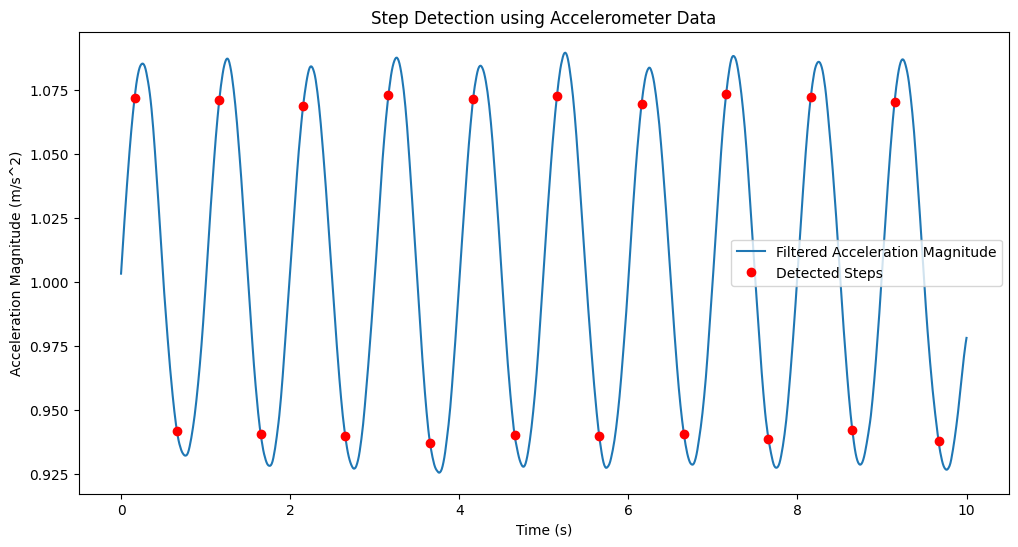

In [262]:

import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

def preprocess_accelerometer_data(ax, ay, az, fs=50):
    """
    Preprocess accelerometer data by computing magnitude and applying a low-pass filter.
    Args:
        ax, ay, az: Accelerometer data along x, y, and z axes.
        fs: Sampling frequency in Hz.
    Returns:
        filtered_magnitude: Filtered acceleration magnitude.
    """
    # Calculate acceleration magnitude
    a_mag = np.sqrt(ax**2 + ay**2 + az**2)
    
    # Low-pass filter to remove high-frequency noise
    nyquist = 0.5 * fs
    low = 2 / nyquist  # Cut-off frequency 2 Hz
    b, a = butter(1, low, btype='low')
    filtered_magnitude = filtfilt(b, a, a_mag)
    
    return filtered_magnitude

def detect_steps(acceleration_magnitude, fs=50, buffer_size=250, dynamic_threshold=True):
    """
    Detect steps using peak and valley detection in the accelerometer data.
    Args:
        acceleration_magnitude: Preprocessed acceleration magnitude.
        fs: Sampling frequency in Hz.
        buffer_size: Size of the buffer for segmenting the data.
        dynamic_threshold: Flag to use dynamic thresholding.
    Returns:
        step_indices: Indices of detected steps.
    """
    step_indices = []
    num_samples = len(acceleration_magnitude)
    
    for start in range(0, num_samples, buffer_size):
        end = min(start + buffer_size, num_samples)
        segment = acceleration_magnitude[start:end]
        
        # Apply moving average filter to smooth the data
        window_size = int(fs * 0.2)  # 0.2 second window
        smooth_segment = np.convolve(segment, np.ones(window_size)/window_size, mode='valid')
        
        # Calculate dynamic threshold if enabled
        if dynamic_threshold:
            threshold = np.mean(smooth_segment) + 0.5 * np.std(smooth_segment)
        else:
            threshold = 1.0
        
        # Find peaks
        peaks, _ = find_peaks(smooth_segment, height=threshold)
        
        # Find valleys (inverted peaks)
        valleys, _ = find_peaks(-smooth_segment, height=-threshold)
        
        # Combine and sort peaks and valleys
        segment_indices = np.sort(np.concatenate((peaks, valleys)))
        
        # Convert segment indices to original data indices
        step_indices.extend(segment_indices + start)
    
    return step_indices

# Simulated accelerometer data for demonstration purposes
def simulate_accelerometer_data(t):
    """
    Simulate accelerometer data for a walking motion.
    Args:
        t: Time array.
    Returns:
        ax, ay, az: Simulated accelerometer data along x, y, and z axes.
    """
    ax = 0.1 * np.sin(2 * np.pi * t) + 0.01 * np.random.randn(len(t))
    ay = 0.1 * np.sin(2 * np.pi * t) + 0.01 * np.random.randn(len(t))
    az = 1.0 + 0.1 * np.sin(2 * np.pi * t) + 0.01 * np.random.randn(len(t))
    return ax, ay, az

def get_steps():
    # Simulated data
    fs = 100  # Sampling frequency in Hz
    duration = 10  # Duration in seconds
    t = np.linspace(0, duration, duration * fs)  # Time array
    ax, ay, az = simulate_accelerometer_data(t)
    
    # Preprocess accelerometer data
    filtered_magnitude = preprocess_accelerometer_data(ax, ay, az, fs)
    
    # Detect steps
    step_indices = detect_steps(filtered_magnitude, fs=fs, buffer_size=250, dynamic_threshold=True)
    return t,filtered_magnitude,step_indices

def plot_step_detection(t,filtered_magnitude,step_indices):
    plt.figure(figsize=(12, 6))
    plt.plot(t, filtered_magnitude, label='Filtered Acceleration Magnitude')
    plt.plot(t[step_indices], filtered_magnitude[step_indices], 'ro', label='Detected Steps')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration Magnitude (m/s^2)')
    plt.title('Step Detection using Accelerometer Data')
    plt.legend()
    plt.show()

t,filtered_magnitude,step_indices = get_steps()
plot_step_detection(t,filtered_magnitude,step_indices)


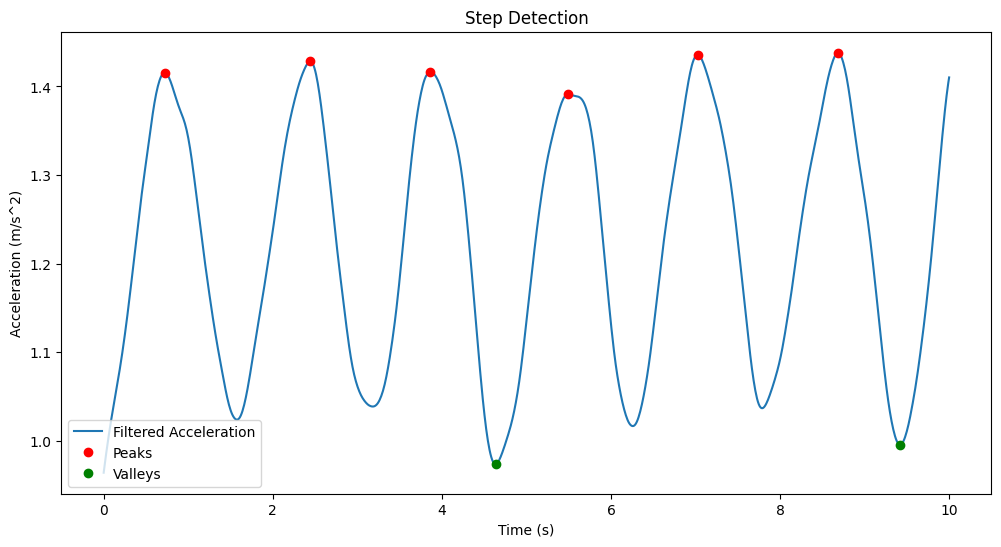

In [263]:
# Sample data (replace with actual sensor data)
time = np.linspace(0, 10, 1000)  # 10 seconds of data
ax = np.sin(time) + np.random.normal(0, 0.1, len(time))  # Simulated accelerometer data
ay = np.cos(time) + np.random.normal(0, 0.1, len(time))  # Simulated accelerometer data
az = np.sin(2 * time) + np.random.normal(0, 0.1, len(time))  # Simulated accelerometer data

# Calculate the net acceleration magnitude (Acc)
Acc = np.sqrt(ax**2 + ay**2 + az**2)

# Adaptive Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Sample parameters for the filter
fs = 100.0  # Sample rate (Hz)
cutoff = 2.0  # Cutoff frequency (Hz)
filtered_Acc = lowpass_filter(Acc, cutoff, fs)

# Peak and valley detection
peaks, _ = find_peaks(filtered_Acc, height=1.0, distance=20)
valleys, _ = find_peaks(-filtered_Acc, height=-1.0, distance=20)

# Verify peaks and valleys using gyroscope and magnetometer data
# (Assume gyroscope and magnetometer data are available)
# gyroscope_data = ...
# magnetometer_data = ...

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time, filtered_Acc, label='Filtered Acceleration')
plt.plot(time[peaks], filtered_Acc[peaks], 'ro', label='Peaks')
plt.plot(time[valleys], filtered_Acc[valleys], 'go', label='Valleys')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.title('Step Detection')
plt.show()


In [264]:
def array_of_values_to_array_of_arrays(array_of_values):
    array_of_arrays = []
    for i in range(len(array_of_values[0])):
        array_of_value = []
        for value in array_of_values:
            array_of_value.append(value[i])
        array_of_arrays.append(np.array(array_of_value))
    return np.array(array_of_arrays)
    

def array_of_arrays_to_array_of_values(array_of_arrays):
    array_of_values = []
    for i in range(len(array_of_arrays[0])):
        array_of_value = []
        for j in range(len(array_of_arrays)):
            array_of_value.append(array_of_arrays[j])
        array_of_values.append(np.array(array_of_value))
    return np.array(array_of_values)



In [265]:
class AdaptiveButterworthFilter:
    def __init__(self, initial_cutoff=2.0, order=2):
        self.order = order
        self.cutoff = initial_cutoff

    def _design_filter(self, cutoff, dt):
        hz = 1/dt
        nyq = 0.5 * hz
        normal_cutoff = cutoff / nyq
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False) 
        return b, a

    def apply_filter(self, data, dt):
        b, a = self._design_filter(self.cutoff, dt)
        return filtfilt(b, a, data)

abwf = AdaptiveButterworthFilter()
abwf.apply_filter(np.array([np.array([1,2,3,4,1,1,1,1,9,7]),np.array([1,2,3,4,1,1,1,8,1,9]),np.array([1,2,3,4,1,1,1,1,0,9])]),0.1)

array([[1.00065268, 2.25602153, 3.06716649, 2.87246118, 1.75796558,
        0.76835441, 1.13864953, 3.19451273, 5.58298701, 7.00056293],
       [0.99920893, 2.25921761, 3.02283459, 2.75609972, 1.77002654,
        1.39050304, 2.251998  , 3.64306772, 5.66542004, 9.00057106],
       [0.9992231 , 2.23003535, 3.03506574, 2.9307371 , 2.02486615,
        0.974545  , 0.16615401, 0.3068156 , 3.13857615, 9.00055207]])

In [266]:
class Buffer:
    def __init__(self,buffer_size,allow_duplicates=False):
        self.index = 0
        self.buffer_size = buffer_size
        self.buffer = []
        self.allow_duplicates = allow_duplicates

    def update_buffer(self,data):
        points = []
        for point in data:
            if self.allow_duplicates or not any(np.array_equal(point, buf_point) for buf_point in self.buffer):
                
                self.buffer.append(point)
                points.append(point)
                if self.buffer_size != -1 and len(self.buffer) > self.buffer_size:
                    self.buffer.pop(0)
        if len(points) > 0:
            self.index += 1
        return points
                    
    def reset_buffer(self):
        self.index = 0
        self.buffer = []

    def set_buffer(self,data):
        self.buffer = data
        self.index = 1
    
    def __str__(self):
        return ",".join(self.buffer)

    def __len__(self):
        return len(self.buffer)
        
    def are_points_equal(self,point1, point2):
        return all(x == y for x, y in zip(point1, point2))


In [267]:
class InterialNavigationSystem:
    def __init__(self,initial_position,initial_quaternion,initial_timestamp):
        self.initial_quaternion = initial_quaternion
        self.device_quaternion =  DeviceQuaternion(initial_quaternion)
        self.pdr = PedestrianDeadReckoning(initial_position)
        self.initial_timestamp = initial_timestamp
        self.current_timestamp = self.initial_timestamp

        #self.user_heading =   # assuming user heading is same as device durring initialization
        
        # self.ekf = ExtendedKalmanFilter(state_dim, measurement_dim, process_noise ,measurement_noise) 
        self.plot = {}
        self.intervals = []
        # self.accel_data = {'ax': [], 'ay': [], 'az': []}
        self.filter = AdaptiveButterworthFilter(initial_cutoff=2.0, order=2)
        self.accel_data = []
        self.peaks = []
        self.valleys = []
        self.accel_buffer = Buffer(11,False)

    def offset(self):
        pass

    def accelerometer_orchestration(self,accel):
        return accel

    def gyroscope_orchestration(self,gyro):
        return gyro

    def magnetometer_orchestration(self,mag):
        return mag

    def calculate_new_user_position(self,data_t):

        new_timestamp = Route.get_timestamp(data_t)
        t = new_timestamp - self.current_timestamp
        dt = t
        self.intervals.append(dt)

        current_position = self.pdr.get_position().copy()
        current_quaternion = self.device_quaternion.get_quaternion().copy()

        gyro = Route.get_gyro_data(data_t) 
        gyro = self.gyroscope_orchestration(gyro)
        accel = Route.get_accel_data(data_t) 
        accel_buffer = Route.get_accel_buffer(data_t) 
        accel_magnitude = self.get_accel_magnitude(data_t,dt)
        accel = self.accelerometer_orchestration(accel)
        mag = Route.get_mag_data(data_t) 
        mag = self.magnetometer_orchestration(mag)


        if len(self.accel_buffer) == 0:
            self.accel_buffer.set_buffer(accel_buffer)
        else:
            self.accel_buffer.update_buffer(accel_buffer)
        # print("buffer:",self.accel_buffer.buffer)
        # print("data:",accel_buffer)
        
        # print("intervals length",len(self.intervals),"index:",self.accel_buffer.index)
        # print(self.intervals)
        
        # detec_step = self.detect_step(data_t,dt)
        
        

        vx = accel[0] * dt
        vy = accel[1] * dt
        vz = accel[2] * dt

        wx = gyro[0] * dt 
        wy = gyro[1] * dt
        wz = gyro[2] * dt

        # roll = current_orientation[0]
        # pitch = current_orientation[1]
        # yaw = current_orientation[2]


        x = current_position[0]
        y = current_position[1]
        z = current_position[2]

        dx = 0
        dy = 0
        dz = 0

        new_x = x + normalize_scale(dx)
        new_y = y + normalize_scale(dy)
        new_z = z + normalize_scale(dz)

        updated_quaternion = update_quaternion(current_quaternion,gyro,dt)
        self.device_quaternion.update_quaternion(updated_quaternion)
        # vertical_displacement = self.calculate_vertical_displacement(data_t,dt)
        # self.pdr.update_position(step_length,heading,vertical_displacement)
        new_position = np.array([new_x,new_y,new_z])
        self.pdr.update_new_position(new_position)



        self.current_timestamp = new_timestamp
        user_state = []
        position = self.pdr.get_position().copy()
        orientation = self.device_quaternion.get_quaternion_as_euler().copy()
        user_state.extend(position)
        user_state.extend(orientation)
        return user_state



    def get_accel_magnitude(self,data_t,dt):
        accel = Route.get_accel_data(data_t) 
        magnitude = self.get_magnitude(accel)
        return magnitude

    def get_magnitude(self,array):
        magnitude = np.linalg.norm(array)
        return magnitude

    def calculate_step_length(self,data_t,dt):
        is_detec_step = self.detect_step(data_t,dt)
        if not is_detec_step:    
            return 0
        step_length = 1
        step_length = normalize_scale(step_length)
        return step_length

    def get_angular_rate(self,data_t,dt):
        gyro = Route.get_gyro_data(data_t)
        angular_rate = gyro * dt 
        return angular_rate


    def calculate_heading(self,data_t,dt):
        return 0
        if magnetometer_data is None:
            return 0
        # Placeholder implementation: customize this method based on your heading estimation algorithm
        heading = np.arctan2(magnetometer_data[1], magnetometer_data[0])  # Simplified example
        heading = normalize_heading(heading)
        return heading


    def calculate_vertical_displacement(self,data_t,dt):
        return 0
        if accelerometer_data is None:
            return 0 
        
        # Placeholder implementation: customize this method based on your vertical displacement estimation algorithm
        vertical_displacement = accelerometer_data[2] * 0.01  # Simplified example
        return vertical_displacement

    def detect_step(self, data_t,dt, peak_height=1.0, peak_distance=20):
        if dt == 0:
            return
        accel = Route.get_accel_data(data_t) 
        magnitude = self.get_accel_magnitude(data_t,dt)
        filtered_acc = self.filter.apply_filter(accel,dt)
        return
        peaks, _ = find_peaks(filtered_acc, height=peak_height, distance=peak_distance)
        valleys, _ = find_peaks(-filtered_acc, height=-peak_height, distance=peak_distance)
        self.acc_data.append(filtered_acc)
        self.peaks.append(peaks)
        self.valleys.append(valleys)


    def plot_results(self):
        """
        Plot the filtered acceleration data along with detected peaks and valleys.

        Parameters:
        time : numpy array
            Time array corresponding to the accelerometer data.
        filtered_Acc : numpy array
            Filtered acceleration data.
        peaks : numpy array
            Indices of detected peaks.
        valleys : numpy array
            Indices of detected valleys.
        """
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.times, self.acc_data, label='Filtered Acceleration')
        plt.plot(self.times[self.peaks], self.acc_data[self.peaks], 'ro', label='Peaks')
        plt.plot(self.times[self.valleys], self.acc_data[self.valleys], 'go', label='Valleys')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s^2)')
        plt.legend()
        plt.title('Step Detection')
        plt.show()



initial_orientation_data,
    quaternion: [0.0431418  0.02401272 0.17388231 0.98352796]
    quaternion to euler rads -> degrees: [79.62569338 20.21929708 95.35104447]

checkpoints indexes: 0 80
points: [{'id': 'node_left_yard_intersect', 'title': 'node_left_yard_intersect', 'pathType': 'edge_align_intersect', 'facilityType': 'none', 'POIId': None, 'isAvailable': True, 'availableHeadings': ['left', 'down', 'right'], 'mapCoordinates': {'x': 466, 'y': 553, 'floor': -1, 'createdAt': '2024-06-13T12:38:07.059Z', 'updatedAt': '2024-06-13T12:38:07.059Z'}, 'createdAt': '2024-06-13T12:38:07.059Z', 'updatedAt': '2024-06-13T12:38:07.059Z'}, {'id': 'node_front_yard_entrance_floor', 'title': 'node_front_yard_entrance_floor', 'pathType': 'edge_align_intersect', 'facilityType': 'none', 'POIId': None, 'isAvailable': True, 'availableHeadings': ['up', 'left', 'right'], 'mapCoordinates': {'x': 628, 'y': 553, 'floor': -1, 'createdAt': '2024-06-13T12:38:07.059Z', 'updatedAt': '2024-06-13T12:38:07.059Z'}, 'c

/tmp/ipykernel_50155/3251076646.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(routes))


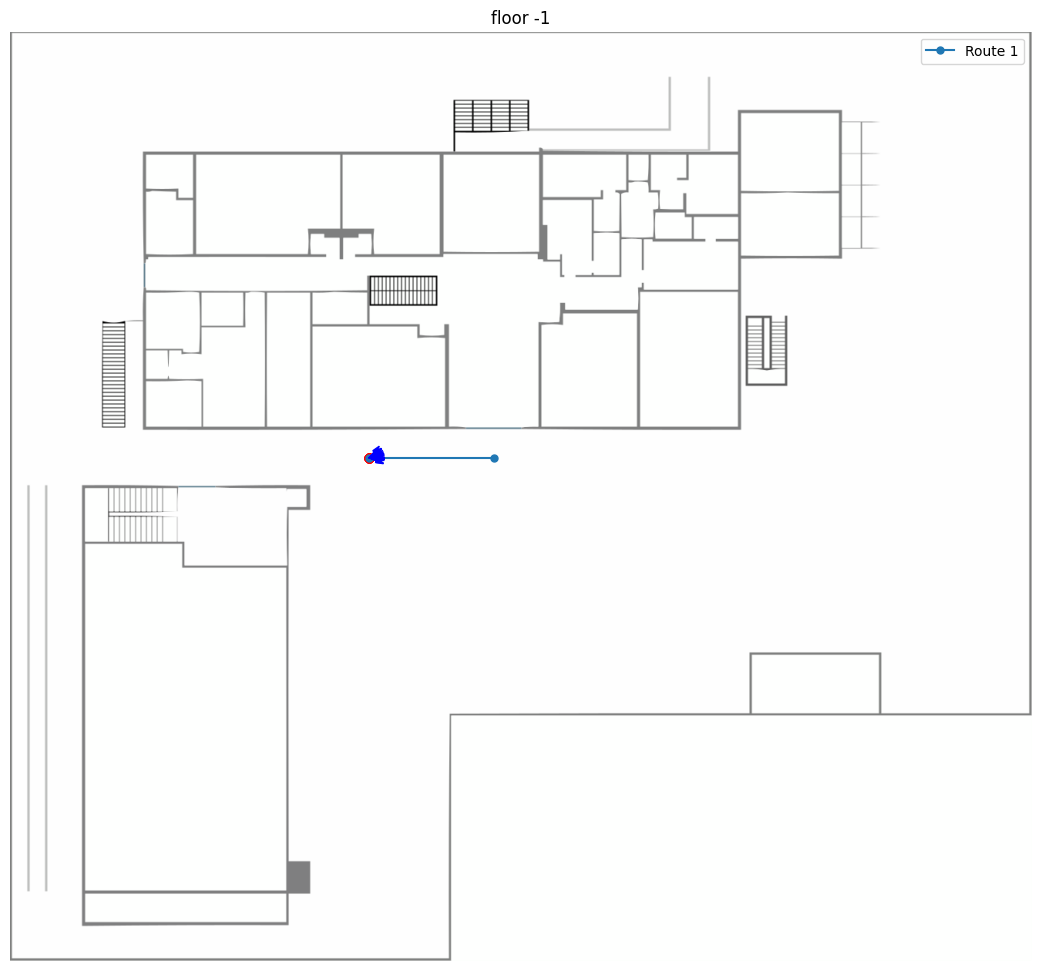

In [303]:
floor_index = 0
route_index = 3
rc = UserRoute(route_index,floor_index)
print(f"""initial_orientation_data,
    quaternion: {rc.initial_quaternion}
    quaternion to euler rads -> degrees: {radians_to_degrees(quaternion.as_euler_angles(quaternion.quaternion(*rc.initial_quaternion)))}
""")

checkpoint = 1
start_index,end_index = rc.points_until_checkpoint(checkpoint)    
print("checkpoints indexes:",start_index,end_index)

def handle_user_state(user_state):
    # print("user_state",user_state)
    pass

func = handle_user_state


rc.calculate(func=func,start_at=start_index,break_at=end_index,every_x=20,specifics=[0])

rc.display_route(route_start_index=checkpoint - 1,route_end_index=checkpoint + 1,skips_specifics=[0],headings_specifics=[1,2],every_x=5)


ValueError: x and y must have same first dimension, but have shapes (81,) and (0,)

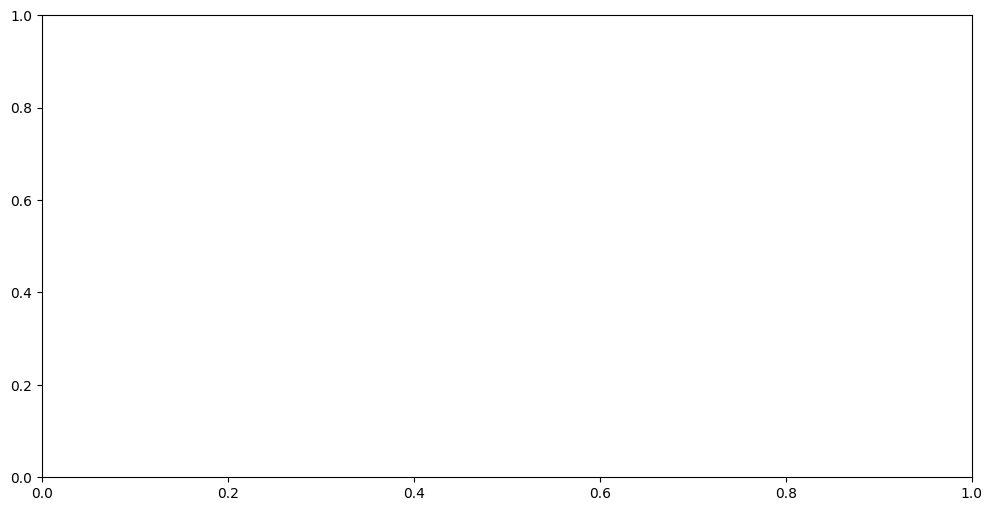

In [92]:
rc.INS.plot_results()

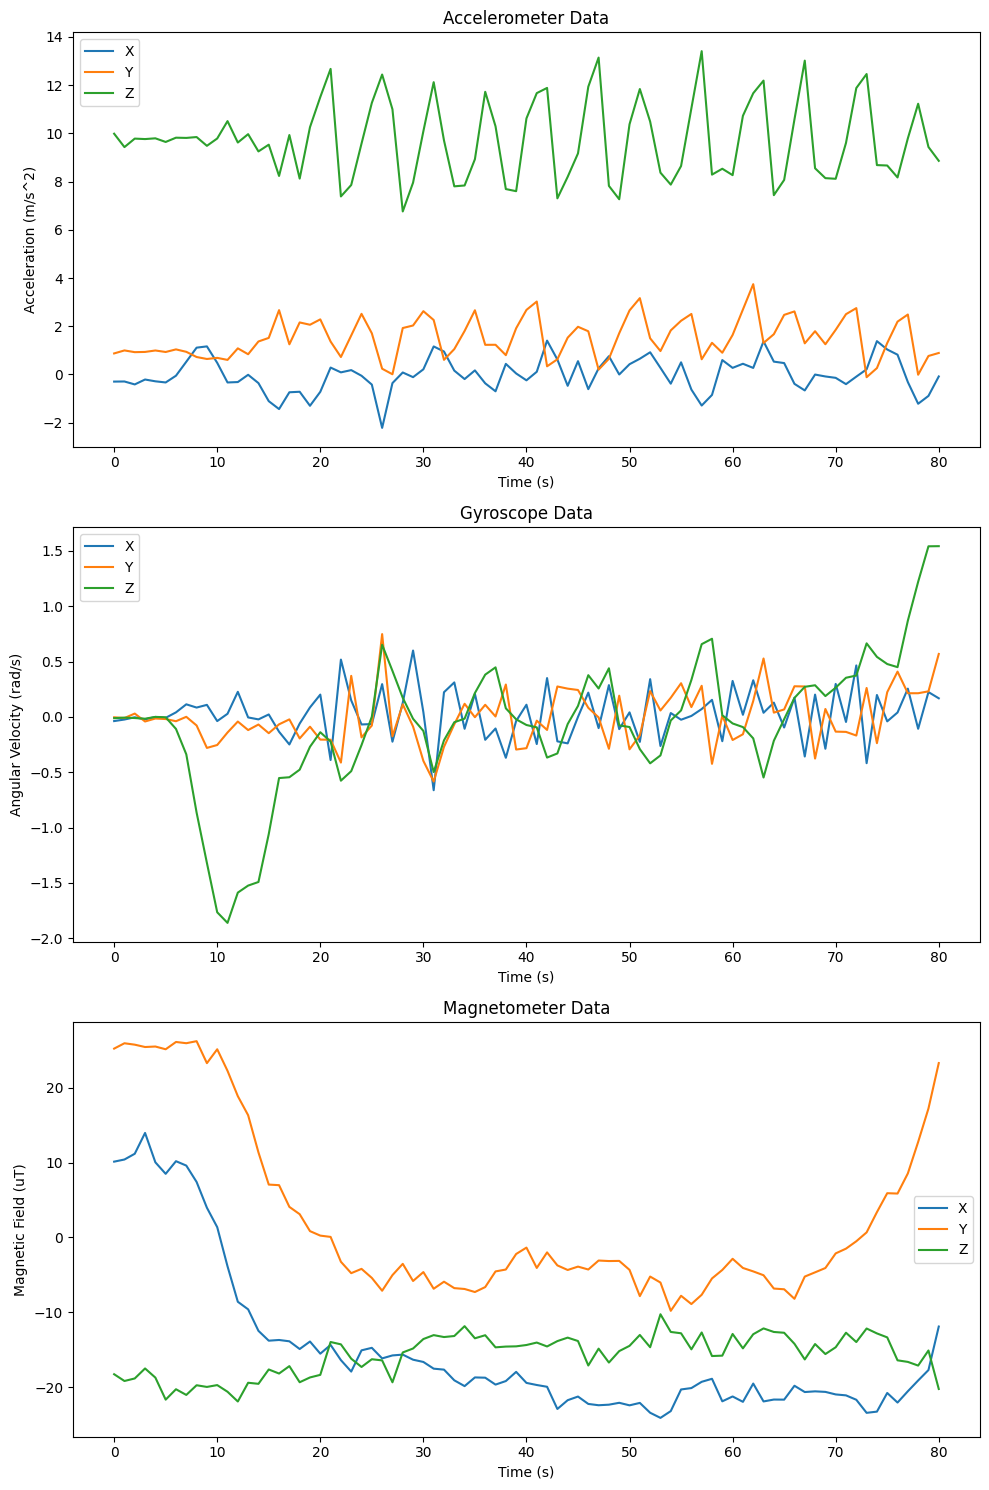

In [265]:
rc.plot_sensor_data()

In [84]:
def ekf_predict(state, covariance, process_noise, dt, accel, gyro):
    """
    Perform the prediction step of the EKF.

    Parameters:
    state: np.ndarray
        The current state vector [x, y, z, vx, vy, vz, qx, qy, qz, qw, wx, wy, wz, err_gy, err_acc, err_mag]
    covariance: np.ndarray
        The current covariance matrix
    process_noise: np.ndarray
        The process noise matrix
    dt: float
        The time step
    accel: np.ndarray
        The acceleration vector [ax, ay, az]
    gyro: np.ndarray
        The gyroscope vector [gx, gy, gz]

    Returns:
    np.ndarray, np.ndarray
        The predicted state and covariance
    """
    # Extract state variables
    velocity = state[3:6]
    orientation = state[6:10]
    angular_velocity = state[10:13]

    # Convert quaternion to rotation matrix
    r = R.from_quat(orientation)
    rotation_matrix = r.as_matrix()

    # Update velocity using acceleration (account for orientation)
    accel_world = rotation_matrix @ accel
    velocity += accel_world * dt

    # Update orientation using gyroscope angular velocity
    omega = gyro * dt
    r = r * R.from_rotvec(omega)
    orientation = r.as_quat()

    # Update angular velocity using gyroscope
    angular_velocity += gyro * dt

    # Update the state vector
    state[3:6] = velocity
    state[6:10] = orientation
    state[10:13] = angular_velocity

    # State transition matrix (F) for 16-state system
    F = np.eye(16)
    F[3:6, 3:6] = np.eye(3)  # Velocity updates

    covariance = F @ covariance @ F.T + process_noise
    return state, covariance


def calculate_route(route_index):
    dt = 0.01
    all_user_states = []    
    route_points,route_checkpoints,route_data = get_route_data(route_index)
    user_state = get_route_start_location(route_index)
    initial_state = user_state_to_state(user_state)
    num_states = len(initial_state)
    state = np.array(initial_state)
    process_noise = np.eye(num_states) * 0.1
    measurement_noise = np.eye(num_states) * 0.1

    # Initialize state covariance matrix
    P = np.eye(num_states)
    # print(route_data)

    for data in route_data:
        if "accelerometer" in data:
            accelerometer_data = data['accelerometer']['data'] # since i save the last 5 values , for step detection , but for now we can just try without
            num_values = len(accelerometer_data)
            last_accelerometer_data = accelerometer_data[num_values - 1]['data']
            z_accel = np.array([last_accelerometer_data['x'] , last_accelerometer_data['y'], last_accelerometer_data['z'] ])

        if 'gyroscope' in data:
            gyroscope_data = data['gyroscope']['data']['data']
            z_gyro = np.array([gyroscope_data['x'], gyroscope_data['y'], gyroscope_data['z']])

        if 'magnetometer' in data:
            magnetometer_data = data['magnetometer']['data']['data']
            z_mag = np.array([magnetometer_data['x'], magnetometer_data['y'], magnetometer_data['z']])


        # Prediction Step
        state, P = ekf_predict(state, P, process_noise, dt, z_accel, z_gyro)
        
        # Update Position using PDR
        step_length = 0.8  # Example step length in meters
        heading_change = np.array([0.1, 0.0, 0.0])  # Example heading change
        state = update_position_with_pdr(state, step_length, heading_change, dt, map_pixel_meter_ratio, map_heading)

        # Update Step with measurements
        # Assuming measurement vector `measurement` and measurement matrix `H` are available
        # Here, we need to provide realistic `measurement` and `H` values based on your data
        measurement = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # Example placeholder
        H = np.eye(num_states)  # Example placeholder
        state, P = ekf_update(state, P, measurement, measurement_noise, H)


        user_state = state_to_user_state(state)
        all_user_states.append(user_state)
        

    return all_user_states








states_route = calculate_route(3)
print(states_route[0])
processed_route = user_states_to_route(states_route)
processed_points = user_states_to_points(states_route)

# print(json.dumps(processed_route,indent=2))

r = routes[3].copy()
# r['route'] = r['route'][0:3]
# print(processed_route['route'][1])
# print([(k['mapCoordinates']['x'],k['mapCoordinates']['y'],k['mapCoordinates']['floor']) for k in r['route']])
ps = processed_points
display_floor_map(building_floor_maps_data[0]['floor'],building_floor_maps_data[0]['file_path'],ps,[r],False)
    

NameError: name 'get_route_start_location' is not defined

In [ ]:
import numpy as np

class ComplementaryFilter:
    def __init__(self, alpha, state_dim):
        self.alpha = alpha
        self.state_dim = state_dim
        self.state = np.zeros(state_dim)

    def update(self, estimate, measurement):
        self.state = self.alpha * estimate + (1 - self.alpha) * measurement

    def get_state(self):
        return self.state

# Example usage:
alpha = 0.98
state_dim = 6

complementary_filter = ComplementaryFilter(alpha, state_dim)

# Example estimate and measurement
estimate = np.array([1, 1, 1, 0, 0, 0])
measurement = np.array([1.1, 0.9, 1.05, 0.05, -0.05, 0])

# Update the filter with the estimate and measurement
complementary_filter.update(estimate, measurement)

# Get the updated state
print("Updated state:", complementary_filter.get_state())


Updated state: [ 1.002  0.998  1.001  0.001 -0.001  0.   ]


In [ ]:

def pdr_algorithm(accelerometer_data, initial_position=[0.0, 0.0, 0.0], dt=0.1):
    """
    Implements a basic Pedestrian Dead Reckoning (PDR) algorithm.

    Parameters:
    - accelerometer_data (list of np.ndarray): List of accelerometer readings over time [[ax1, ay1, az1], [ax2, ay2, az2], ...]
    - initial_position (list or np.ndarray): Initial position [x, y, z]
    - dt (float): Time step between accelerometer readings

    Returns:
    - list of np.ndarray: List of estimated positions over time [[x1, y1, z1], [x2, y2, z2], ...]
    """
    position = np.array(initial_position)
    positions = [position.copy()]

    for accel_data in accelerometer_data:
        displacement = calculate_displacement(accel_data, dt)
        position += displacement
        positions.append(position.copy())

    return positions

In [ ]:
import numpy as np

class ExtendedKalmanFilter:
    def __init__(self, state_dim, meas_dim, state_transition, measurement_function, state_jacobian, measurement_jacobian):
        self.state_dim = state_dim
        self.meas_dim = meas_dim
        self.state_transition = state_transition
        self.measurement_function = measurement_function
        self.state_jacobian = state_jacobian
        self.measurement_jacobian = measurement_jacobian

        self.state = np.zeros(state_dim)
        self.covariance = np.eye(state_dim)
        self.process_noise = np.eye(state_dim)
        self.measurement_noise = np.eye(meas_dim)

    def predict(self, control_input=None):
        # Predict state
        self.state = self.state_transition(self.state, control_input)
        # Compute Jacobian of the state transition function
        F = self.state_jacobian(self.state, control_input)
        # Predict covariance
        self.covariance = F @ self.covariance @ F.T + self.process_noise

    def update(self, measurement):
        # Predict measurement
        predicted_meas = self.measurement_function(self.state)
        # Compute Jacobian of the measurement function
        H = self.measurement_jacobian(self.state)
        # Compute Kalman Gain
        S = H @ self.covariance @ H.T + self.measurement_noise
        K = self.covariance @ H.T @ np.linalg.inv(S)
        # Update state
        self.state = self.state + K @ (measurement - predicted_meas)
        # Update covariance
        self.covariance = (np.eye(self.state_dim) - K @ H) @ self.covariance

    def set_initial_state(self, state):
        self.state = state

    def set_process_noise(self, process_noise):
        self.process_noise = process_noise

    def set_measurement_noise(self, measurement_noise):
        self.measurement_noise = measurement_noise

    def get_state(self):
        return self.state

    def get_covariance(self):
        return self.covariance

# Example usage:
def state_transition(state, control_input):
    # Example: simple linear motion model
    A = np.eye(len(state))
    return A @ state

def measurement_function(state):
    # Example: direct measurement model
    H = np.eye(len(state))
    return H @ state

def state_jacobian(state, control_input):
    # Jacobian of the state transition function (here it's the identity matrix)
    return np.eye(len(state))

def measurement_jacobian(state):
    # Jacobian of the measurement function (here it's the identity matrix)
    return np.eye(len(state))

# Initialize EKF with state dimension 6 and measurement dimension 6
ekf = ExtendedKalmanFilter(
    state_dim=6,
    meas_dim=6,
    state_transition=state_transition,
    measurement_function=measurement_function,
    state_jacobian=state_jacobian,
    measurement_jacobian=measurement_jacobian
)

# Set initial state and noise matrices
ekf.set_initial_state(np.array([0, 0, 0, 0, 0, 0]))
ekf.set_process_noise(np.eye(6) * 0.1)
ekf.set_measurement_noise(np.eye(6) * 0.1)

# Predict and update steps
ekf.predict()
measurement = np.array([1, 1, 1, 0, 0, 0])  # Example measurement
ekf.update(measurement)

# Get the updated state
print("Updated state:", ekf.get_state())


Updated state: [0.917 0.917 0.917 0.    0.    0.   ]


In [ ]:
import numpy as np

class ParticleFilter:
    def __init__(self, num_particles, state_dim, state_transition, measurement_function):
        self.num_particles = num_particles
        self.state_dim = state_dim
        self.state_transition = state_transition
        self.measurement_function = measurement_function
        self.particles = np.random.randn(num_particles, state_dim)
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, control_input=None):
        for i in range(self.num_particles):
            self.particles[i] = self.state_transition(self.particles[i], control_input)

    def update(self, measurement):
        for i in range(self.num_particles):
            self.weights[i] = self.measurement_function(self.particles[i], measurement)
        self.weights += 1.e-300  # avoid division by zero
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = np.random.choice(range(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def get_state(self):
        return np.average(self.particles, axis=0, weights=self.weights)

# Example usage:
def state_transition(state, control_input):
    # Example: simple linear motion model with some noise
    A = np.eye(len(state))
    noise = np.random.randn(len(state)) * 0.1
    return A @ state + noise

def measurement_function(particle, measurement):
    # Example: direct measurement model with Gaussian noise
    H = np.eye(len(particle))
    predicted_measurement = H @ particle
    error = measurement - predicted_measurement
    return np.exp(-0.5 * np.dot(error, error))  # Gaussian likelihood

num_particles = 1000
state_dim = 6

particle_filter = ParticleFilter(
    num_particles=num_particles,
    state_dim=state_dim,
    state_transition=state_transition,
    measurement_function=measurement_function
)

# Predict step
particle_filter.predict()

# Example measurement
measurement = np.array([1, 1, 1, 0, 0, 0])

# Update step
particle_filter.update(measurement)

# Resample particles
particle_filter.resample()

# Get the estimated state
print("Estimated state:", particle_filter.get_state())


Estimated state: [0.435 0.476 0.512 0.067 0.052 0.007]


In [ ]:
 
# Author: Addison Sears-Collins
# https://automaticaddison.com
# Description: Extended Kalman Filter example (two-wheeled mobile robot)
 
# Supress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3,suppress=True)
 
# A matrix
# 3x3 matrix -> number of states x number of states matrix
# Expresses how the state of the system [x,y,yaw] changes 
# from k-1 to k when no control command is executed.
# Typically a robot on wheels only drives when the wheels are told to turn.
# For this case, A is the identity matrix.
# A is sometimes F in the literature.
A_k_minus_1 = np.array([[1.0,  0,   0],
                                                [  0,1.0,   0],
                                                [  0,  0, 1.0]])
 
# Noise applied to the forward kinematics (calculation
# of the estimated state at time k from the state
# transition model of the mobile robot). This is a vector
# with the number of elements equal to the number of states
process_noise_v_k_minus_1 = np.array([0.01,0.01,0.003])
     
# State model noise covariance matrix Q_k
# When Q is large, the Kalman Filter tracks large changes in 
# the sensor measurements more closely than for smaller Q.
# Q is a square matrix that has the same number of rows as states.
Q_k = np.array([[1.0,   0,   0],
                                [  0, 1.0,   0],
                                [  0,   0, 1.0]])
                 
# Measurement matrix H_k
# Used to convert the predicted state estimate at time k
# into predicted sensor measurements at time k.
# In this case, H will be the identity matrix since the 
# estimated state maps directly to state measurements from the 
# odometry data [x, y, yaw]
# H has the same number of rows as sensor measurements
# and same number of columns as states.
H_k = np.array([[1.0,  0,   0],
                                [  0,1.0,   0],
                                [  0,  0, 1.0]])
                         
# Sensor measurement noise covariance matrix R_k
# Has the same number of rows and columns as sensor measurements.
# If we are sure about the measurements, R will be near zero.
R_k = np.array([[1.0,   0,    0],
                                [  0, 1.0,    0],
                                [  0,    0, 1.0]])  
                 
# Sensor noise. This is a vector with the
# number of elements equal to the number of sensor measurements.
sensor_noise_w_k = np.array([0.07,0.07,0.04])
 
def getB(yaw, deltak):
    """
    Calculates and returns the B matrix
    3x2 matix -> number of states x number of control inputs
    The control inputs are the forward speed and the
    rotation rate around the z axis from the x-axis in the 
    counterclockwise direction.
    [v,yaw_rate]
    Expresses how the state of the system [x,y,yaw] changes
    from k-1 to k due to the control commands (i.e. control input).
    :param yaw: The yaw angle (rotation angle around the z axis) in rad 
    :param deltak: The change in time from time step k-1 to k in sec
    """
    B = np.array([  [np.cos(yaw)*deltak, 0],
                                    [np.sin(yaw)*deltak, 0],
                                    [0, deltak]])
    return B
 
def ekf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk):
    """
    Extended Kalman Filter. Fuses noisy sensor measurement to 
    create an optimal estimate of the state of the robotic system.
         
    INPUT
        :param z_k_observation_vector The observation from the Odometry
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param state_estimate_k_minus_1 The state estimate at time k-1
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param control_vector_k_minus_1 The control vector applied at time k-1
            3x1 NumPy Array [v,v,yaw rate] in the global reference frame
            in [meters per second,meters per second,radians per second].
        :param P_k_minus_1 The state covariance matrix estimate at time k-1
            3x3 NumPy Array
        :param dk Time interval in seconds
             
    OUTPUT
        :return state_estimate_k near-optimal state estimate at time k  
            3x1 NumPy Array ---> [meters,meters,radians]
        :return P_k state covariance_estimate for time k
            3x3 NumPy Array                 
    """
    ######################### Predict #############################
    # Predict the state estimate at time k based on the state 
    # estimate at time k-1 and the control input applied at time k-1.
    state_estimate_k = A_k_minus_1 @ (
            state_estimate_k_minus_1) + (
            getB(state_estimate_k_minus_1[2],dk)) @ (
            control_vector_k_minus_1) + (
            process_noise_v_k_minus_1)
             
    print(f'State Estimate Before EKF={state_estimate_k}')
             
    # Predict the state covariance estimate based on the previous
    # covariance and some noise
    P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + (
            Q_k)
         
    ################### Update (Correct) ##########################
    # Calculate the difference between the actual sensor measurements
    # at time k minus what the measurement model predicted 
    # the sensor measurements would be for the current timestep k.
    measurement_residual_y_k = z_k_observation_vector - (
            (H_k @ state_estimate_k) + (
            sensor_noise_w_k))
 
    print(f'Observation={z_k_observation_vector}')
             
    # Calculate the measurement residual covariance
    S_k = H_k @ P_k @ H_k.T + R_k
         
    # Calculate the near-optimal Kalman gain
    # We use pseudoinverse since some of the matrices might be
    # non-square or singular.
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
         
    # Calculate an updated state estimate for time k
    state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)
     
    # Update the state covariance estimate for time k
    P_k = P_k - (K_k @ H_k @ P_k)
     
    # Print the best (near-optimal) estimate of the current state of the robot
    print(f'State Estimate After EKF={state_estimate_k}')
 
    # Return the updated state and covariance estimates
    return state_estimate_k, P_k
     
def main():
 
    # We start at time k=1
    k = 1
     
    # Time interval in seconds
    dk = 1
 
    # Create a list of sensor observations at successive timesteps
    # Each list within z_k is an observation vector.
    z_k = np.array([[4.721,0.143,0.006], # k=1
                    [9.353,0.284,0.007], # k=2
                    [14.773,0.422,0.009],# k=3
                    [18.246,0.555,0.011], # k=4
                    [22.609,0.715,0.012]])# k=5
                     
    # The estimated state vector at time k-1 in the global reference frame.
    # [x_k_minus_1, y_k_minus_1, yaw_k_minus_1]
    # [meters, meters, radians]
    state_estimate_k_minus_1 = np.array([0.0,0.0,0.0])
     
    # The control input vector at time k-1 in the global reference frame.
    # [v, yaw_rate]
    # [meters/second, radians/second]
    # In the literature, this is commonly u.
    # Because there is no angular velocity and the robot begins at the 
    # origin with a 0 radians yaw angle, this robot is traveling along 
    # the positive x-axis in the global reference frame.
    control_vector_k_minus_1 = np.array([4.5,0.0])
     
    # State covariance matrix P_k_minus_1
    # This matrix has the same number of rows (and columns) as the 
    # number of states (i.e. 3x3 matrix). P is sometimes referred
    # to as Sigma in the literature. It represents an estimate of 
    # the accuracy of the state estimate at time k made using the
    # state transition matrix. We start off with guessed values.
    P_k_minus_1 = np.array([[0.1,  0,   0],
                                                    [  0,0.1,   0],
                                                    [  0,  0, 0.1]])
                             
    # Start at k=1 and go through each of the 5 sensor observations, 
    # one at a time. 
    # We stop right after timestep k=5 (i.e. the last sensor observation)
    for k, obs_vector_z_k in enumerate(z_k,start=1):
     
        # Print the current timestep
        print(f'Timestep k={k}')  
         
        # Run the Extended Kalman Filter and store the 
        # near-optimal state and covariance estimates
        optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k, # Most recent sensor measurement
            state_estimate_k_minus_1, # Our most recent estimate of the state
            control_vector_k_minus_1, # Our most recent control input
            P_k_minus_1, # Our most recent state covariance matrix
            dk) # Time interval
         
        # Get ready for the next timestep by updating the variable values
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k
         
        # Print a blank line
        print()

In [ ]:
 
# Author: Addison Sears-Collins
# https://automaticaddison.com
# Description: Extended Kalman Filter example (two-wheeled mobile robot)
 
# Supress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3,suppress=True)
 
# A matrix
# 3x3 matrix -> number of states x number of states matrix
# Expresses how the state of the system [x,y,yaw] changes 
# from k-1 to k when no control command is executed.
# Typically a robot on wheels only drives when the wheels are told to turn.
# For this case, A is the identity matrix.
# A is sometimes F in the literature.
base = [
    [  1.0, 0  , 0  , 0  ],
    [  0  , 1.0, 0  , 0  ],
    [  0  , 0  , 1.0, 0  ],
    [  0  , 0  , 0  , 1.0]
]

A_k_minus_1 = np.array(base)
 
# Noise applied to the forward kinematics (calculation
# of the estimated state at time k from the state
# transition model of the mobile robot). This is a vector
# with the number of elements equal to the number of states
process_noise_v_k_minus_1 = np.array([
    0.01,
    0.01,
    0.01, 
    0.003
])
     
# State model noise covariance matrix Q_k
# When Q is large, the Kalman Filter tracks large changes in 
# the sensor measurements more closely than for smaller Q.
# Q is a square matrix that has the same number of rows as states.
Q_k = np.array(base)
                 
# Measurement matrix H_k
# Used to convert the predicted state estimate at time k
# into predicted sensor measurements at time k.
# In this case, H will be the identity matrix since the 
# estimated state maps directly to state measurements from the 
# odometry data [x, y, yaw]
# H has the same number of rows as sensor measurements
# and same number of columns as states.
H_k = np.array(base)
                         
# Sensor measurement noise covariance matrix R_k
# Has the same number of rows and columns as sensor measurements.
# If we are sure about the measurements, R will be near zero.
R_k = np.array(base)  
                 
# Sensor noise. This is a vector with the
# number of elements equal to the number of sensor measurements.
sensor_noise_w_k = np.array([
    0.07,
    0.07,
    0.07,
    0.04
])
 
def getB(yaw, deltak):
    """
    Calculates and returns the B matrix
    3x2 matix -> number of states x number of control inputs
    The control inputs are the forward speed and the
    rotation rate around the z axis from the x-axis in the 
    counterclockwise direction.
    [v,yaw_rate]
    Expresses how the state of the system [x,y,yaw] changes
    from k-1 to k due to the control commands (i.e. control input).
    :param yaw: The yaw angle (rotation angle around the z axis) in rad 
    :param deltak: The change in time from time step k-1 to k in sec
    """
    B = np.array([  [np.cos(yaw)*deltak, 0],
                                    [np.sin(yaw)*deltak, 0],
                                    [0, deltak]])
    return B
 
def ekf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk):
    """
    Extended Kalman Filter. Fuses noisy sensor measurement to 
    create an optimal estimate of the state of the robotic system.
         
    INPUT
        :param z_k_observation_vector The observation from the Odometry
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param state_estimate_k_minus_1 The state estimate at time k-1
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param control_vector_k_minus_1 The control vector applied at time k-1
            3x1 NumPy Array [v,v,yaw rate] in the global reference frame
            in [meters per second,meters per second,radians per second].
        :param P_k_minus_1 The state covariance matrix estimate at time k-1
            3x3 NumPy Array
        :param dk Time interval in seconds
             
    OUTPUT
        :return state_estimate_k near-optimal state estimate at time k  
            3x1 NumPy Array ---> [meters,meters,radians]
        :return P_k state covariance_estimate for time k
            3x3 NumPy Array                 
    """
    ######################### Predict #############################
    # Predict the state estimate at time k based on the state 
    # estimate at time k-1 and the control input applied at time k-1.
    state_estimate_k = A_k_minus_1 @ (
            state_estimate_k_minus_1) + (
            getB(state_estimate_k_minus_1[2],dk)) @ (
            control_vector_k_minus_1) + (
            process_noise_v_k_minus_1)
             
    print(f'State Estimate Before EKF={state_estimate_k}')
             
    # Predict the state covariance estimate based on the previous
    # covariance and some noise
    P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + (
            Q_k)
         
    ################### Update (Correct) ##########################
    # Calculate the difference between the actual sensor measurements
    # at time k minus what the measurement model predicted 
    # the sensor measurements would be for the current timestep k.
    measurement_residual_y_k = z_k_observation_vector - (
            (H_k @ state_estimate_k) + (
            sensor_noise_w_k))
 
    print(f'Observation={z_k_observation_vector}')
             
    # Calculate the measurement residual covariance
    S_k = H_k @ P_k @ H_k.T + R_k
         
    # Calculate the near-optimal Kalman gain
    # We use pseudoinverse since some of the matrices might be
    # non-square or singular.
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
         
    # Calculate an updated state estimate for time k
    state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)
     
    # Update the state covariance estimate for time k
    P_k = P_k - (K_k @ H_k @ P_k)
     
    # Print the best (near-optimal) estimate of the current state of the robot
    print(f'State Estimate After EKF={state_estimate_k}')
 
    # Return the updated state and covariance estimates
    return state_estimate_k, P_k
     
def main():
 
    # We start at time k=1
    k = 1
     
    # Time interval in seconds
    dk = 1
 
    # Create a list of sensor observations at successive timesteps
    # Each list within z_k is an observation vector.
    z_k = np.array([[4.721,0.143,0.006], # k=1
                    [9.353,0.284,0.007], # k=2
                    [14.773,0.422,0.009],# k=3
                    [18.246,0.555,0.011], # k=4
                    [22.609,0.715,0.012]])# k=5
                     
    # The estimated state vector at time k-1 in the global reference frame.
    # [x_k_minus_1, y_k_minus_1, yaw_k_minus_1]
    # [meters, meters, radians]
    state_estimate_k_minus_1 = np.array([0.0,0.0,0.0])
     
    # The control input vector at time k-1 in the global reference frame.
    # [v, yaw_rate]
    # [meters/second, radians/second]
    # In the literature, this is commonly u.
    # Because there is no angular velocity and the robot begins at the 
    # origin with a 0 radians yaw angle, this robot is traveling along 
    # the positive x-axis in the global reference frame.
    control_vector_k_minus_1 = np.array([4.5,0.0])
     
    # State covariance matrix P_k_minus_1
    # This matrix has the same number of rows (and columns) as the 
    # number of states (i.e. 3x3 matrix). P is sometimes referred
    # to as Sigma in the literature. It represents an estimate of 
    # the accuracy of the state estimate at time k made using the
    # state transition matrix. We start off with guessed values.
    P_k_minus_1 = np.array([
        [0.1,  0,     0 ,0],
        [0,    0.1,   0 , 0],
        [  0,  0, 0.1 , 0],
        [  0,  0, 0, 0.1]

                        ]
                    )
                             
    # Start at k=1 and go through each of the 5 sensor observations, 
    # one at a time. 
    # We stop right after timestep k=5 (i.e. the last sensor observation)
    for k, obs_vector_z_k in enumerate(z_k,start=1):
     
        # Print the current timestep
        print(f'Timestep k={k}')  
         
        # Run the Extended Kalman Filter and store the 
        # near-optimal state and covariance estimates
        optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k, # Most recent sensor measurement
            state_estimate_k_minus_1, # Our most recent estimate of the state
            control_vector_k_minus_1, # Our most recent control input
            P_k_minus_1, # Our most recent state covariance matrix
            dk) # Time interval
         
        # Get ready for the next timestep by updating the variable values
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k
        print()
        # Print a blank line
main()

Timestep k=1


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)

In [ ]:
import numpy as np

# Supress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3, suppress=True)

def initialize_matrices(num_states, process_noise_std, sensor_noise_std):
    """
    Initialize matrices for EKF.
    """
    A_k_minus_1 = np.eye(num_states)
    process_noise_v_k_minus_1 = np.full(num_states, process_noise_std)
    Q_k = np.eye(num_states)
    H_k = np.eye(num_states)
    R_k = np.eye(num_states) * sensor_noise_std
    sensor_noise_w_k = np.full(num_states, sensor_noise_std)
    
    return A_k_minus_1, process_noise_v_k_minus_1, Q_k, H_k, R_k, sensor_noise_w_k

def getB(yaw, deltak):
    """
    Calculates and returns the B matrix
    """
    B = np.array([
        [np.cos(yaw) * deltak, 0],
        [np.sin(yaw) * deltak, 0],
        [0, deltak]
    ])
    return B

def ekf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk, 
        A_k_minus_1, process_noise_v_k_minus_1, Q_k, H_k, R_k, sensor_noise_w_k):
    """
    Extended Kalman Filter.
    """
    ######################### Predict #############################
    state_estimate_k = A_k_minus_1 @ state_estimate_k_minus_1 + getB(state_estimate_k_minus_1[2], dk) @ control_vector_k_minus_1 + process_noise_v_k_minus_1
    print(f'State Estimate Before EKF={state_estimate_k}')
    
    P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + Q_k
    
    ################### Update (Correct) ##########################
    measurement_residual_y_k = z_k_observation_vector - (H_k @ state_estimate_k + sensor_noise_w_k)
    print(f'Observation={z_k_observation_vector}')
    
    S_k = H_k @ P_k @ H_k.T + R_k
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
    
    state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)
    P_k = P_k - (K_k @ H_k @ P_k)
    
    print(f'State Estimate After EKF={state_estimate_k}')
    
    return state_estimate_k, P_k

def main():
    # Number of states
    num_states = 3  # Modify this as needed

    # Process and sensor noise standard deviations
    process_noise_std = 0.01
    sensor_noise_std = 0.07

    # Initialize matrices
    A_k_minus_1, process_noise_v_k_minus_1, Q_k, H_k, R_k, sensor_noise_w_k = initialize_matrices(num_states, process_noise_std, sensor_noise_std)
    
    # Time interval in seconds
    dk = 1
    
    # Create a list of sensor observations at successive timesteps
    z_k = np.array([
        [4.721, 0.143, 0.006],  # k=1
        [9.353, 0.284, 0.007],  # k=2
        [14.773, 0.422, 0.009], # k=3
        [18.246, 0.555, 0.011], # k=4
        [22.609, 0.715, 0.012]  # k=5
    ])
    
    # Initial state estimate
    state_estimate_k_minus_1 = np.zeros(num_states)
    
    # Control input vector
    control_vector_k_minus_1 = np.array([4.5, 0.0])
    
    # Initial state covariance matrix P_k_minus_1
    P_k_minus_1 = np.eye(num_states) * 0.1
    
    # Run EKF for each observation
    for k, obs_vector_z_k in enumerate(z_k, start=1):
        print(f'Timestep k={k}')
        
        optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k, 
            state_estimate_k_minus_1, 
            control_vector_k_minus_1, 
            P_k_minus_1, 
            dk, 
            A_k_minus_1, 
            process_noise_v_k_minus_1, 
            Q_k, 
            H_k, 
            R_k, 
            sensor_noise_w_k
        )
        
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k
        
        print()

if __name__ == "__main__":
    main()


Timestep k=1
State Estimate Before EKF=[4.51 0.01 0.01]
Observation=[4.721 0.143 0.006]
State Estimate After EKF=[ 4.643  0.069 -0.06 ]

Timestep k=2
State Estimate Before EKF=[ 9.145 -0.189 -0.05 ]
Observation=[9.353 0.284 0.007]
State Estimate After EKF=[ 9.274  0.189 -0.062]

Timestep k=3
State Estimate Before EKF=[13.776 -0.08  -0.052]
Observation=[14.773  0.422  0.009]
State Estimate After EKF=[14.646  0.325 -0.06 ]

Timestep k=4
State Estimate Before EKF=[19.148  0.063 -0.05 ]
Observation=[18.246  0.555  0.011]
State Estimate After EKF=[18.236  0.459 -0.058]

Timestep k=5
State Estimate Before EKF=[22.738  0.206 -0.048]
Observation=[22.609  0.715  0.012]
State Estimate After EKF=[22.551  0.618 -0.057]



In [ ]:
user_state = {
    orientation:{
        roll:0,
        pitch:0,
        yaw:0
    },
    position:{
        x:0,
        y:0,
        z:0,
    },
    extra:{
        # anything can be error of w.e like idk , gps , accelerometer, gyrsocrope magentomer ,
        # not only ereror can be other stuff i guess
    }
}

 

{'x': 466,
 'y': 553,
 'floor': -1,
 'createdAt': '2024-06-13T12:38:07.059Z',
 'updatedAt': '2024-06-13T12:38:07.059Z'}

In [ ]:
import numpy as np

# Suppress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3, suppress=True)

def initialize_matrices(num_states, process_noise_std, sensor_noise_std):
    """
    Initialize matrices for EKF.
    """
    A_k_minus_1 = np.eye(num_states)
    process_noise_v_k_minus_1 = np.full(num_states, process_noise_std)
    Q_k = np.eye(num_states)
    H_k = np.eye(num_states)
    R_k = np.eye(num_states) * sensor_noise_std
    sensor_noise_w_k = np.full(num_states, sensor_noise_std)
    
    return A_k_minus_1, process_noise_v_k_minus_1, Q_k, H_k, R_k, sensor_noise_w_k

def getB(yaw, deltak):
    """
    Calculates and returns the B matrix.
    """
    B = np.zeros((9, 2))  # Adjusted for 9 state variables (3 for orientation, 3 for position, and 3 for extra)
    B[0, 0] = np.cos(yaw) * deltak
    B[1, 0] = np.sin(yaw) * deltak
    B[5, 1] = deltak  # Assuming the second control input affects the yaw
    return B

def ekf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk, 
        A_k_minus_1, process_noise_v_k_minus_1, Q_k, H_k, R_k, sensor_noise_w_k):
    """
    Extended Kalman Filter.
    """
    ######################### Predict #############################
    state_estimate_k = A_k_minus_1 @ state_estimate_k_minus_1 + getB(state_estimate_k_minus_1[2], dk) @ control_vector_k_minus_1 + process_noise_v_k_minus_1
    print(f'State Estimate Before EKF={state_estimate_k}')
    
    P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + Q_k
    
    ################### Update (Correct) ##########################
    measurement_residual_y_k = z_k_observation_vector - (H_k @ state_estimate_k + sensor_noise_w_k)
    print(f'Observation={z_k_observation_vector}')
    
    S_k = H_k @ P_k @ H_k.T + R_k
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
    
    state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)
    P_k = P_k - (K_k @ H_k @ P_k)
    
    print(f'State Estimate After EKF={state_estimate_k}')
    
    return state_estimate_k, P_k

def flatten_user_state(user_state):
    """
    Flatten the user state dictionary into a single state vector.
    """
    return np.array([
        user_state['orientation']['roll'],
        user_state['orientation']['pitch'],
        user_state['orientation']['yaw'],
        user_state['position']['x'],
        user_state['position']['y'],
        user_state['position']['z'],
        user_state['extra'].get('gps', 0),
        user_state['extra'].get('accelerometer', 0),
        user_state['extra'].get('gyroscope', 0)
    ])

def main():
    # Define the user state
    user_state = {
        'orientation': {
            'roll': 0,
            'pitch': 0,
            'yaw': 0
        },
        'position': {
            'x': 0,
            'y': 0,
            'z': 0
        },
        'extra': {
            'gps': 0,
            'accelerometer': 0,
            'gyroscope': 0
        }
    }

    # Flatten the user state to create the initial state estimate
    state_estimate_k_minus_1 = flatten_user_state(user_state)
    
    # Number of states
    num_states = len(state_estimate_k_minus_1)

    # Process and sensor noise standard deviations
    process_noise_std = 0.01
    sensor_noise_std = 0.07

    # Initialize matrices
    A_k_minus_1, process_noise_v_k_minus_1, Q_k, H_k, R_k, sensor_noise_w_k = initialize_matrices(num_states, process_noise_std, sensor_noise_std)
    
    # Time interval in seconds
    dk = 1
    
    # Create a list of sensor observations at successive timesteps
    z_k = np.array([
        [4.721, 0.143, 0.006, 1, 1, 1, 0, 0, 0],  # k=1
        [9.353, 0.284, 0.007, 2, 2, 2, 0, 0, 0],  # k=2
        [14.773, 0.422, 0.009, 3, 3, 3, 0, 0, 0], # k=3
        [18.246, 0.555, 0.011, 4, 4, 4, 0, 0, 0], # k=4
        [22.609, 0.715, 0.012, 5, 5, 5, 0, 0, 0]  # k=5
    ])
    
    # Control input vector
    control_vector_k_minus_1 = np.array([4.5, 0.0])
    
    # Initial state covariance matrix P_k_minus_1
    P_k_minus_1 = np.eye(num_states) * 0.1
    
    # Run EKF for each observation
    for k, obs_vector_z_k in enumerate(z_k, start=1):
        print(f'Timestep k={k}')
        
        optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k, 
            state_estimate_k_minus_1, 
            control_vector_k_minus_1, 
            P_k_minus_1, 
            dk, 
            A_k_minus_1, 
            process_noise_v_k_minus_1, 
            Q_k, 
            H_k, 
            R_k, 
            sensor_noise_w_k
        )
        
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k
        
        print()

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np

class ExtendedKalmanFilter:
    def __init__(self, dt, process_noise, measurement_noise, initial_state, initial_covariance):
        self.dt = dt  # Time step
        
        # State vector [px, py, pz, vx, vy, vz, qx, qy, qz, qw, bgx, bgy, bgz]
        self.x = initial_state
        
        # State covariance matrix
        self.P = initial_covariance
        
        # Process noise covariance matrix
        self.Q = process_noise
        
        # Measurement noise covariance matrix
        self.R = measurement_noise
        
        # Identity matrix
        self.I = np.eye(len(self.x))
    
    def predict(self):
        # Predict the state (assuming constant velocity and orientation)
        # Here, more sophisticated motion models can be used.
        
        # State transition matrix (linearized for small dt)
        F = np.eye(len(self.x))
        F[0, 3] = self.dt
        F[1, 4] = self.dt
        F[2, 5] = self.dt

        # Predict state
        self.x = F @ self.x
        
        # Predict state covariance
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z, H, h):
        # Measurement residual
        y = z - h(self.x)
        
        # Measurement covariance
        S = H @ self.P @ H.T + self.R
        
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state
        self.x = self.x + K @ y
        
        # Update state covariance
        self.P = (self.I - K @ H) @ self.P

    def h(self, state):
        # Measurement model
        px, py, pz, vx, vy, vz, qx, qy, qz, qw, bgx, bgy, bgz = state
        # Assuming we measure acceleration and gyroscope data (simplified model)
        ax = 2 * (qw*qy + qx*qz) * 9.81
        ay = 2 * (qy*qz - qw*qx) * 9.81
        az = (qw*qw - qx*qx - qy*qy + qz*qz) * 9.81
        wx = 0
        wy = 0
        wz = 0
        mx = 0
        my = 0
        mz = 0
        return np.array([ax, ay, az, wx, wy, wz, mx, my, mz])

# Initial state [px, py, pz, vx, vy, vz, qx, qy, qz, qw, bgx, bgy, bgz]
initial_state = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

# Initial covariance matrix
initial_covariance = np.eye(13) * 0.1

# Process noise covariance matrix
process_noise = np.eye(13) * 0.1

# Measurement noise covariance matrix
measurement_noise = np.eye(9) * 0.1

# Time step
dt = 0.01

ekf = ExtendedKalmanFilter(dt, process_noise, measurement_noise, initial_state, initial_covariance)

# Example sensor data update
gravity_data = np.array([9.677294731140137, 1.56982421875, -0.23666709661483765])
linear_acceleration_data = np.array([0.1652688980102539, -0.07105398178100586, -0.32118189334869385])
accelerometer_data = np.array([0.6560112833976746, 2.1523873805999756, 11.046846389770508])
magnetometer_data = np.array([2.4880001544952393, 29.50200080871582, -34.85100173950195])
rotation_vector_data = np.array([0.08014104515314102, 0.01314217783510685, 0.012864996679127216, 0.9966139197349548])
gyroscope_data = np.array([-0.10690141469240189, 0.05192354694008827, -0.08429940044879913])

# Combine all measurement data
z = np.hstack((accelerometer_data, gyroscope_data, magnetometer_data))

# Define measurement matrix (H) and measurement function (h)
H = np.eye(9, 13)
def h(x):
    # Measurement function should map the state to the measurement vector
    return ekf.h(x)

# EKF predict and update
ekf.predict()
ekf.update(z, H, h)

print("Updated state vector:")
print(ekf.x)


Updated state vector:
[  0.437   1.435  13.905  -0.071   0.037  -0.033   2.659  19.668 -23.234
   0.      0.      0.      0.   ]


In [ ]:
test_route_data[0]

{'gravity': {'timestamp': '2024-06-17T17:38:20.903Z',
  'data': {'eventMode': 'continuous',
   'sensorName': 'Samsung Gravity Sensor',
   'firstEventAfterDiscontinuity': False,
   'timestamp': 1718645900776,
   'rawTimestamp': '324973001913697',
   'event': 'data',
   'data': {'z': 9.75883674621582,
    'y': 0.9141082763671875,
    'x': -0.31607985496520996},
   'rawData': [-0.31607985496520996, 0.9141082763671875, 9.75883674621582]}},
 'linear': {'timestamp': '2024-06-17T17:38:20.903Z',
  'data': {'eventMode': 'continuous',
   'sensorName': 'Samsung Linear Acceleration Sensor',
   'firstEventAfterDiscontinuity': False,
   'timestamp': 1718645900776,
   'rawTimestamp': '324973001913697',
   'event': 'data',
   'data': {'z': 0.2704744338989258,
    'y': -0.04980146884918213,
    'x': 0.04074665904045105},
   'rawData': [0.04074665904045105,
    -0.04980146884918213,
    0.2704744338989258]}},
 'accelerometer': {'timestamp': '2024-06-17T17:38:20.902Z',
  'data': [{'eventMode': 'continuou

In [ ]:
print(test_route_points[1])


{'x': 628, 'y': 553, 'floor': -1, 'createdAt': '2024-06-13T12:38:07.059Z', 'updatedAt': '2024-06-13T12:38:07.059Z'}
{'index': 1, 'point': {'id': 'node_front_yard_entrance_floor', 'title': 'node_front_yard_entrance_floor', 'pathType': 'edge_align_intersect', 'facilityType': 'none', 'POIId': None, 'isAvailable': True, 'availableHeadings': ['up', 'left', 'right'], 'mapCoordinates': {'x': 628, 'y': 553, 'floor': -1, 'createdAt': '2024-06-13T12:38:07.059Z', 'updatedAt': '2024-06-13T12:38:07.059Z'}, 'createdAt': '2024-06-13T12:38:07.059Z', 'updatedAt': '2024-06-13T12:38:07.059Z'}, 'time': '2024-06-17T17:38:29.665Z'}


{'_id': '667074dc1a0682e297d773eb',
 'buildingId': 'e384f534f12c984588d8868e',
 'routeName': 'route1_static_infront_start_north',
 'route': [{'id': 'node_left_yard_intersect',
   'title': 'node_left_yard_intersect',
   'pathType': 'edge_align_intersect',
   'facilityType': 'none',
   'POIId': None,
   'isAvailable': True,
   'availableHeadings': ['left', 'down', 'right'],
   'mapCoordinates': {'x': 466,
    'y': 553,
    'floor': -1,
    'createdAt': '2024-06-13T12:38:07.059Z',
    'updatedAt': '2024-06-13T12:38:07.059Z'},
   'createdAt': '2024-06-13T12:38:07.059Z',
   'updatedAt': '2024-06-13T12:38:07.059Z'},
  {'id': 'node_front_yard_entrance_floor',
   'title': 'node_front_yard_entrance_floor',
   'pathType': 'edge_align_intersect',
   'facilityType': 'none',
   'POIId': None,
   'isAvailable': True,
   'availableHeadings': ['up', 'left', 'right'],
   'mapCoordinates': {'x': 628,
    'y': 553,
    'floor': -1,
    'createdAt': '2024-06-13T12:38:07.059Z',
    'updatedAt': '2024-06-13

User states over time:


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

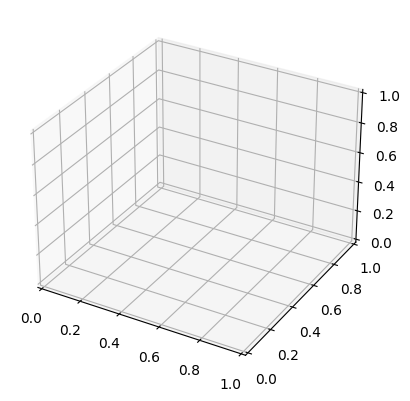

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize user state
user_state = {
    'orientation': {
        'roll': 0,
        'pitch': 0,
        'yaw': 0
    },
    'position': {
        'x': 0,
        'y': 0,
        'z': 0
    },
}

# Initialize state vector [x, y, z, vx, vy, vz, qx, qy, qz, qw]
state = np.zeros(10)

# Initialize state covariance matrix
P = np.eye(10)

# Define process noise covariance matrix
Q = np.eye(10) * 0.01

# Define measurement noise covariance matrix
R_accel = np.eye(3) * 0.1
R_gyro = np.eye(3) * 0.1

# Example sensor data list
sensor_data_list = [
    # Add multiple sensor data points here
]

def ekf_predict(state, P, Q, dt):
    # State transition model for position and orientation
    F = np.eye(10)
    F[0:3, 3:6] = np.eye(3) * dt  # Position update
    # Orientation update using angular velocity would be more complex, involving quaternion multiplication
    
    # Predict state
    state = F @ state
    
    # Predict state covariance
    P = F @ P @ F.T + Q
    
    return state, P

def ekf_update(state, P, z, R, H):
    y = z - H @ state  # Innovation
    S = H @ P @ H.T + R  # Innovation covariance
    K = P @ H.T @ np.linalg.inv(S)  # Kalman gain
    
    # Update state estimate
    state = state + K @ y
    
    # Update state covariance
    I = np.eye(len(state))
    P = (I - K @ H) @ P
    
    return state, P

# Time step
dt = 0.01

# List to store user states
user_states = []

# Iterate over the sensor data list
for sensor_data in sensor_data_list:
    # Predict step
    state, P = ekf_predict(state, P, Q, dt)

    # Update step for accelerometer (position update)
    z_accel = np.array([sensor_data['accelerometer']['x'], sensor_data['accelerometer']['y'], sensor_data['accelerometer']['z']])
    H_accel = np.zeros((3, 10))
    H_accel[0:3, 0:3] = np.eye(3)
    state, P = ekf_update(state, P, z_accel, R_accel, H_accel)

    # Update step for gyroscope (orientation update)
    z_gyro = np.array([sensor_data['gyroscope']['x'], sensor_data['gyroscope']['y'], sensor_data['gyroscope']['z']])
    H_gyro = np.zeros((3, 10))
    H_gyro[0:3, 6:9] = np.eye(3)
    state, P = ekf_update(state, P, z_gyro, R_gyro, H_gyro)

    # Extract the user's position
    user_state['position']['x'] = state[0]
    user_state['position']['y'] = state[1]
    user_state['position']['z'] = state[2]

    # Extract the user's orientation (converting quaternion to roll, pitch, yaw)
    qx, qy, qz, qw = state[6:10]
    sinr_cosp = 2 * (qw * qx + qy * qz)
    cosr_cosp = 1 - 2 * (qx * qx + qy * qy)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    sinp = 2 * (qw * qy - qz * qx)
    pitch = np.arcsin(sinp) if np.abs(sinp) <= 1 else np.pi/2 * np.sign(sinp)

    siny_cosp = 2 * (qw * qz + qx * qy)
    cosy_cosp = 1 - 2 * (qy * qy + qz * qz)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    user_state['orientation']['roll'] = roll
    user_state['orientation']['pitch'] = pitch
    user_state['orientation']['yaw'] = yaw

    # Append the current user state to the list
    user_states.append(user_state.copy())

# Example output
print("User states over time:")
for i, state in enumerate(user_states):
    print(f"Time {i*dt:.2f}s: Position (x, y, z) = ({state['position']['x']}, {state['position']['y']}, {state['position']['z']})")

# Plotting the positions
positions = np.array([(state['position']['x'], state['position']['y'], state['position']['z']) for state in user_states])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
plt.show()


In [ ]:
[p for p in test_route_data if p['wifi']]


KeyError: 'wifi'

In [ ]:
wifi_filename = "wifi_data.csv"
wifi_data = pd.read_csv(wifi_filename)
wifi_data.columns.values

array(['version', 'buiildingId', 'x', 'y', 'floor', 'SSID', 'level',
       'timestamp', 'frequency', 'BSSID', 'capabilities', 'uploadedAt'],
      dtype=object)

In [ ]:
import numpy as np

# Initialize user state
user_state = {
    'orientation': {
        'roll': 0,
        'pitch': 0,
        'yaw': 0
    },
    'position': {
        'x': 0,
        'y': 0,
        'z': 0
    },
}

# Initialize state vector [x, y, z, vx, vy, vz, qx, qy, qz, qw]
state = np.zeros(10)

# Initialize state covariance matrix
P = np.eye(10)

# Define process noise covariance matrix
Q = np.eye(10) * 0.01

# Define measurement noise covariance matrix
R_accel = np.eye(3) * 0.1
R_gyro = np.eye(3) * 0.1

# Example sensor data
sensor_data = {
    'gravity': {'x': -0.23666709661483765, 'y': 1.56982421875, 'z': 9.677294731140137},
    'linear': {'x': -0.32118189334869385, 'y': -0.07105398178100586, 'z': 0.1652688980102539},
    'accelerometer': {'x': 0.6560112833976746, 'y': 2.1523873805999756, 'z': 11.046846389770508},
    'magnetometer': {'x': 2.4880001544952393, 'y': 29.50200080871582, 'z': -34.85100173950195},
    'rotationVector': {'qx': 0.08014104515314102, 'qy': 0.01314217783510685, 'qz': 0.012864996679127216, 'qw': 0.9966139197349548},
    'gyroscope': {'x': -0.10690141469240189, 'y': 0.05192354694008827, 'z': -0.08429940044879913}
}

def ekf_predict(state, P, Q, dt):
    # State transition model for position and orientation
    F = np.eye(10)
    F[0:3, 3:6] = np.eye(3) * dt  # Position update
    # Orientation update using angular velocity would be more complex, involving quaternion multiplication
    
    # Predict state
    state = F @ state
    
    # Predict state covariance
    P = F @ P @ F.T + Q
    
    return state, P

def ekf_update(state, P, z, R, H):
    y = z - H @ state  # Innovation
    S = H @ P @ H.T + R  # Innovation covariance
    K = P @ H.T @ np.linalg.inv(S)  # Kalman gain
    
    # Update state estimate
    state = state + K @ y
    
    # Update state covariance
    I = np.eye(len(state))
    P = (I - K @ H) @ P
    
    return state, P

# Time step
dt = 0.01

# Predict step
state, P = ekf_predict(state, P, Q, dt)

# Update step for accelerometer (position update)
z_accel = np.array([sensor_data['accelerometer']['x'], sensor_data['accelerometer']['y'], sensor_data['accelerometer']['z']])
H_accel = np.zeros((3, 10))
H_accel[0:3, 0:3] = np.eye(3)
state, P = ekf_update(state, P, z_accel, R_accel, H_accel)

# Update step for gyroscope (orientation update)
z_gyro = np.array([sensor_data['gyroscope']['x'], sensor_data['gyroscope']['y'], sensor_data['gyroscope']['z']])
H_gyro = np.zeros((3, 10))
H_gyro[0:3, 6:9] = np.eye(3)
state, P = ekf_update(state, P, z_gyro, R_gyro, H_gyro)

# Extract the user's position
user_state['position']['x'] = state[0]
user_state['position']['y'] = state[1]
user_state['position']['z'] = state[2]

# Extract the user's orientation (converting quaternion to roll, pitch, yaw)
qx, qy, qz, qw = state[6:10]
sinr_cosp = 2 * (qw * qx + qy * qz)
cosr_cosp = 1 - 2 * (qx * qx + qy * qy)
roll = np.arctan2(sinr_cosp, cosr_cosp)

sinp = 2 * (qw * qy - qz * qx)
pitch = np.arcsin(sinp) if np.abs(sinp) <= 1 else np.pi/2 * np.sign(sinp)

siny_cosp = 2 * (qw * qz + qx * qy)
cosy_cosp = 1 - 2 * (qy * qy + qz * qz)
yaw = np.arctan2(siny_cosp, cosy_cosp)

user_state['orientation']['roll'] = roll
user_state['orientation']['pitch'] = pitch
user_state['orientation']['yaw'] = yaw

# Example output
print("Updated user state:")
print(user_state)


Updated user state:
{'orientation': {'roll': -0.00742139186422096, 'pitch': -0.01492281802481276, 'yaw': -0.009342628555941078}, 'position': {'x': 0.5969164916313765, 'y': 1.9584960752581164, 'z': 10.05172465391153}}


In [ ]:
def ekf_predict(state, P, Q, dt):
    # State transition model for position and orientation
    F = np.eye(10)
    F[0:3, 3:6] = np.eye(3) * dt  # Position update
    # Orientation update using angular velocity would be more complex, involving quaternion multiplication
    
    # Predict state
    state = F @ state
    
    # Predict state covariance
    P = F @ P @ F.T + Q
    
    return state, P

def ekf_update(state, P, z, R, H):
    y = z - H @ state  # Innovation
    S = H @ P @ H.T + R  # Innovation covariance
    K = P @ H.T @ np.linalg.inv(S)  # Kalman gain
    
    # Update state estimate
    state = state + K @ y
    
    # Update state covariance
    I = np.eye(len(state))
    P = (I - K @ H) @ P
    
    return state, P

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Define state vector and covariance matrix
state = np.zeros(10)  # [x, y, z, vx, vy, vz, qx, qy, qz, qw]
covariance = np.eye(10)  # Initial covariance matrix

# Process noise and measurement noise
process_noise = np.eye(10) * 0.1
measurement_noise = np.eye(10) * 0.1

def ekf_predict(state, covariance, dt, accel, gyro):
    # Update position
    state[0:3] += state[3:6] * dt + 0.5 * accel * dt**2  # x, y, z update
    state[3:6] += accel * dt  # vx, vy, vz update

    # Update orientation
    omega = gyro * dt
    r = R.from_quat(state[6:10])
    r = r * R.from_rotvec(omega)
    state[6:10] = r.as_quat()

    # Update covariance
    F = np.eye(10)
    F[0:3, 3:6] = np.eye(3) * dt
    F[3:6, 6:10] = np.eye(3) * dt  # Simplified

    covariance = F @ covariance @ F.T + process_noise
    return state, covariance

def ekf_update(state, covariance, measurement):
    H = np.eye(10)  # Measurement matrix
    K = covariance @ H.T @ np.linalg.inv(H @ covariance @ H.T + measurement_noise)  # Kalman gain
    state = state + K @ (measurement - H @ state)
    covariance = (np.eye(10) - K @ H) @ covariance
    return state, covariance

# Example data point
data_point = {
    'gravity': {'data': {'x': -0.23666709661483765, 'y': 1.56982421875, 'z': 9.677294731140137}},
    'linear': {'data': {'x': -0.32118189334869385, 'y': -0.07105398178100586, 'z': 0.1652688980102539}},
    'gyroscope': {'data': {'x': -0.10690141469240189, 'y': 0.05192354694008827, 'z': -0.08429940044879913}}
}

dt = 0.01  # Time step

# Extract sensor data
accel = np.array([data_point['linear']['data']['x'], data_point['linear']['data']['y'], data_point['linear']['data']['z']])
gyro = np.array([data_point['gyroscope']['data']['x'], data_point['gyroscope']['data']['y'], data_point['gyroscope']['data']['z']])

# Predict step
state, covariance = ekf_predict(state, covariance, dt, accel, gyro)

# Measurement update (example using gravity sensor)
measurement = np.zeros(10)
measurement[0:3] = [0, 0, 0]  # Assume position measurements are zero
measurement[6:10] = [0, 0, 0, 1]  # Assume orientation is identity quaternion

state, covariance = ekf_update(state, covariance, measurement)

print("Updated State:")
print(f"Position: {state[0:3]}")
print(f"Velocity: {state[3:6]}")
print(f"Orientation (quaternion): {state[6:10]}")


ValueError: Found zero norm quaternions in `quat`.

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Initialize state vector [x, y, z, vx, vy, vz, qx, qy, qz, qw]
state = np.zeros(10)

# Initialize state covariance matrix
P = np.eye(10)

# Define process noise covariance matrix
Q = np.eye(10) * 0.01

# Define measurement noise covariance matrix
R_accel = np.eye(3) * 0.1
R_gyro = np.eye(3) * 0.1
R_mag = np.eye(3) * 0.1

# Example sensor data
sensor_data = {
    'gravity': {'x': -0.23666709661483765, 'y': 1.56982421875, 'z': 9.677294731140137},
    'linear': {'x': -0.32118189334869385, 'y': -0.07105398178100586, 'z': 0.1652688980102539},
    'accelerometer': {'x': 0.6560112833976746, 'y': 2.1523873805999756, 'z': 11.046846389770508},
    'magnetometer': {'x': 2.4880001544952393, 'y': 29.50200080871582, 'z': -34.85100173950195},
    'rotationVector': {'qx': 0.08014104515314102, 'qy': 0.01314217783510685, 'qz': 0.012864996679127216, 'qw': 0.9966139197349548},
    'gyroscope': {'x': -0.10690141469240189, 'y': 0.05192354694008827, 'z': -0.08429940044879913}
}



# Time step
dt = 0.01

# Predict step
state, P = ekf_predict(state, P, Q, dt)

# Update step for accelerometer (position update)
z_accel = np.array([sensor_data['accelerometer']['x'], sensor_data['accelerometer']['y'], sensor_data['accelerometer']['z']])
H_accel = np.zeros((3, 10))
H_accel[0:3, 0:3] = np.eye(3)
state, P = ekf_update(state, P, z_accel, R_accel, H_accel)

# Update step for gyroscope (orientation update)
z_gyro = np.array([sensor_data['gyroscope']['x'], sensor_data['gyroscope']['y'], sensor_data['gyroscope']['z']])
H_gyro = np.zeros((3, 10))
H_gyro[0:3, 6:9] = np.eye(3)
state, P = ekf_update(state, P, z_gyro, R_gyro, H_gyro)

# Example output
print("Updated state vector:")
print(state)


Updated state vector:
[ 0.597  1.958 10.052  0.006  0.019  0.1   -0.097  0.047 -0.077  0.   ]
